### Genetic Algorithm - NSGA II

---------------

1. Se importan las librerías que hacen falta para el código. En caso de necesitar instalar librerías que no se tengan, se utiliza el comando puesto en cada línea en comentarios:

In [1]:
# Librería Numpy para manejo de arrays
import numpy as np

# Librería de Scipy
from scipy.spatial.transform import Rotation as R # para rotaciones espaciales
from scipy.interpolate import RegularGridInterpolator # para interpolaciones en una grid regular

# Librería para leer archivos DICOM y manejar DVHs
import pydicom as dicom # !pip install pydicom
from rt_utils import RTStructBuilder # !pip install rt-utils

# Librería para referenciar archivos en el sistema operativo
import os

# Librería para generar identificadores únicos universales (necesario referenciar documentos DICOM)
import uuid

# Librería para manejo de copias de objetos
import copy

# Librería que maneja la fecha y hora
from datetime import datetime

# Librería para rellenar los contornos 
import cv2 # !pip install opencv-python

------------------------

In [2]:
def extraer_coordenadas_tiempos(plan, coords_canales, tiempo_final):
    """
    Esta función extra las coordenadas y los tiempos correspondientes a cada dwell position
    de cada canal para el caso de un plan general.

    Inputs:
    - plan: Dataset del RT Plan general del tratamiento

    Outputs:
    - coords_canales: Diccionario para almacenar las coordenadas de cada canal
    - tiempo_final: Diccionario para almacenar los tiempo finales de cada dwell position
    """

    # Variables auxiliares
    lista_coordenadas = []  # Lista para almacenar todas las coordenadas
    dic_ctw = {}  # Diccionario para almacenar los tiempos asociados a cada coordenada (Cumulative Time Weight)
    inicio_slicing = 0  # Índice para el inicio del slicing de las coordenadas

    # Se define el dataset de los canales del plan (suponiendo que solo hay un Application Setup, que es lo más común)
    canales = plan.ApplicationSetupSequence[0].ChannelSequence

    # Se recorre cada canal para extraer sus coordenadas y tiempos
    for i in range(len(canales)):

        # Se comprueba que el canal tiene la información necesaria
        if hasattr (canales[i],'ChannelNumber') and hasattr (canales[i],'ChannelTotalTime') and hasattr (canales[i],'FinalCumulativeTimeWeight'):

            # Se guarda el canal actual, su tiempo final acumulado y su tiempo total
            channel_number = canales[i].ChannelNumber
            tiempo_acumulado = canales[i].FinalCumulativeTimeWeight
            tiempo_total = canales[i].ChannelTotalTime

            # Se define el dataset de las dwell positions y sus tiempos del canal actual
            dataset_dwell = canales[i].BrachyControlPointSequence

            # Se recorre solo la mitad de puntos, ya que estos están siempre duplicados (por eso se hace //2 y no tiene riesgo de dar error ya que el número de dwell positions siempre es par)
            for j in range(len(dataset_dwell)//2):
                
                # Se extraen las coordenadas y los tiempos (siempre se extraen los impares, ya que los pares son idénticas)
                coordenadas = dataset_dwell[2 * j + 1].ControlPoint3DPosition
                tiempos = dataset_dwell[2 * j + 1].CumulativeTimeWeight

                # Si el tiempo es diferente de None o las coordenadas de 0.0, se guarda la información
                if  tiempos != tiempos != 'None' or coordenadas != '0.0':
                    coordenadas = np.round(np.array(coordenadas),5)
                    lista_coordenadas.append(coordenadas)
                    dic_ctw[tuple(coordenadas)] = float(tiempos)
                
                else:
                    continue

            # Despues de recorrer todos los puntos del canal, se indexan las coordenadas en el diccionario final con llave el número de canal
            # Se hace el slicing de la lista de coordenadas desde el índice de inicio hasta el final del diccionario de tiempos acumulados
            coords_canales[channel_number] = lista_coordenadas[inicio_slicing:len(dic_ctw)]
            inicio_slicing = len(dic_ctw)

            # Se calculan los tiempos finales asociados a cada dwell position del canal actual y se guardan en el diccionario de tiempos finales
            coord_actual = coords_canales[channel_number]

            if tiempo_acumulado == 0:
                for n in range(len(coord_actual)):
                    tiempo_final[tuple(coord_actual[n])] = 0
                continue

            # Si la lista contiene alguna coordenada, se calcula su tiempo asociado
            if len(coord_actual) > 0: 
                # Se recorren las coordenadas actuales para calcular sus tiempos finales
                for n in range(len(coord_actual)):

                    # Para la coordenada n-ésima, su tiempo final es la diferencia entre el tiempo actual y el anterior, multiplicado por el factor de conversión (tiempo_total/tiempo_acumulado)
                    if n > 0:
                        tiempo_final[tuple(coord_actual[n])] = (dic_ctw[tuple(coord_actual[n])] - dic_ctw[tuple(coord_actual[n-1])]) * (tiempo_total/tiempo_acumulado)
            
                    # Para la primera coordenada, su tiempo final es simplemente el tiempo actual multiplicado por el factor de conversión (tiempo_total/tiempo_acumulado)
                    else: 
                        tiempo_final[tuple(coord_actual[n])] = dic_ctw[tuple(coord_actual[n])] * (tiempo_total/tiempo_acumulado)
            else:
                continue

In [3]:
def obtener_vectores_directores(canales, vectores_directores):
    """
    Función que se encarga de obtener los vectores directores tangentes a cada uno de los dwell position.
    
    Inputs:
    - canales: Diccionario donde se almacenan las coordenadas de los puntos de cada canal

    Outputs:
    - vectores_directores: Diccionario donde se almacenan los vectores directores con su correspondiente llave (que son las coordenadas)
    """
    
    # Se recorre cada canal
    for i in canales.keys():
        
        # Si solo hay una posición de permanencia
        if len(canales[i]) < 2:
            vectores_directores[tuple(canales[i][0])] = canales[i][0] / np.linalg.norm(canales[i][0])

        # Si hay más de una posición de permanencia
        else:
            # Se recorre cada dwell position del canal actual
            for j in range(len(canales[i])):

                # Si es el primer elemento, se calcula como la diferencia del siguiente (j+1) con el actual (j)
                if j == 0:
                    vectores_directores[tuple(canales[i][j])] = canales[i][j+1] - canales[i][j]

                # Si es un elemento entre medio, se calcula como la diferencia del siguiente (j+1) con el anterior (j-1) respecto a (j)
                if (j != 0) and (j != (len(canales[i])-1)):
                    vectores_directores[tuple(canales[i][j])] = canales[i][j+1] - canales[i][j-1]

                # Si es el último elemento, se calcula como la diferencia entre el actual (j) con el anterior (j-1)
                if j == (len(canales[i])-1):
                    vectores_directores[tuple(canales[i][j])] = canales[i][j] - canales[i][j-1]

                # Se normalizan los vectores directores (se le agrega el menos para que apunten en el sentido hacia la primera posición de permanencia)
                vectores_directores[tuple(canales[i][j])] = -(vectores_directores[tuple(canales[i][j])]) / np.linalg.norm(vectores_directores[tuple(canales[i][j])])

In [4]:
def obtener_rotores(vectores_directores, rotores_finales):
    """
    Función que extrae los rotores para cada elemento en función de las coordenadas de referencia escogidas.
    Estos rotores sirven para saber cuanto deben rotar las coordenadas centradas para que sigan la anisotropía
    del dwell point que se quiere obtener.
    
    Input:
    - coords_ref: Coordenadas de la dwell point de referencia
    - vectores_directores: Diccionario donde se almacenan los vectores directores de cada dwell position

    Output:
    - rotores: Diccionario donde se almacenan los rotores de cada dwell position
    """

    # En todo este código se utiliza como vector de referencia el de la fuente de referencia (que siempre apunta en z)
    vector_director_ref = np.array([0,0,1])

    # Se recorre cada uno de los vectores directores para calcular su rotor asociado
    for elemento in vectores_directores:
    
        # Se calcula el vecetor perpendicular a los dos vectores tangentes 
        # (el de la posición de referencia y el vector seleccionado)    
        rot_vector = np.cross(vectores_directores[elemento],vector_director_ref)

        # Si el vector de rotación es distinto de cero, se calcula el rotor
        if np.linalg.norm(rot_vector) > 1e-8:

            # Se normaliza el vector perpendicular a la dirección de rotación
            rot_vector = rot_vector/np.linalg.norm(rot_vector)

            # Se calcula el ángulo que se tiene que rotar (se usa la función clip para evitar errores numéricos que den valores fuera del dominio de arccos)
            angle = np.arccos(np.clip(np.dot(vectores_directores[elemento], vector_director_ref), -1.0, 1.0))

            # Se aplica el elemento R.from_vector con el ángulo vector que se quiere rotar (el vector unitario de rotación por el ángulo)
            rotation_matrix = R.from_rotvec((angle)*rot_vector)

        else:
            # Si no hace falta rotación, se construye el vector de rotación nulo
            rotation_matrix = R.from_rotvec([0,0,0])
    
        # Se guarda el rotor en el diccionario con su correspondiente estructura (las coordenadas)
        rotores_finales[elemento] = rotation_matrix

In [5]:
def obtener_mascaras(estructuras):
    """"
    Función que extrae las máscaras 3D de cada una de las estructuras por separado.
    
    Input:
    - Estructuras: clase definida mediante la librería rt-utils

    Output:
    - masks_dict: Diccionario con las máscaras
    """

    # Obtener todos los nombres de las ROIs
    roi_names = estructuras.get_roi_names()

    # Diccionario para guardar las máscaras
    masks_dict = {}

    # Extraer la máscara de cada ROI
    for roi_name in roi_names:
            mask = estructuras.get_roi_mask_by_name(roi_name)
            if np.any(mask):  # Solo guardar si tiene contenido
                masks_dict[roi_name] = mask

    return masks_dict

In [6]:
def interpolar_contornos_faltantes(mask_3d):
    """
    Función que interpola los contornos faltantes en una máscara 3D. 
    Rellena slices vacíos entre slices con contornos mediante interpolación de formas (distance transform).
    
    Input:
    - mask_3d : Máscara binaria 3D.
                                 
    Output:
    - filled_mask: Máscara 3D con los slices intermedios interpolados.
    """
    from scipy.ndimage import distance_transform_edt

    # Detectar cuál es el eje de los slices (asumimos que es el que tiene menos dimensiones o el primero/último)
    # En DICOM y numpy suele ser (Z, Y, X) -> eje 0, o (Y, X, Z) -> eje 2
    # Aquí asumiremos que si la máscara viene de RTStructBuilder suele ser (Y, X, Z)
    # Pero para trabajar mejor, vamos a asegurarnos de trabajar en (Z, Y, X)
    
    # El eje Z suele ser el más corto en MRI/CT comparado con 512x512
    # O si viene de rt-utils, suele ser (Row, Col, Slice) -> (Y, X, Z)
    # Vamos a asumir formato (Y, X, Z) y lo transponemos a (Z, Y, X) para iterar fácil
    if mask_3d.shape[2] < mask_3d.shape[0] and mask_3d.shape[2] < mask_3d.shape[1]:

        # Probablemente (Y, X, Z)
        working_mask = mask_3d.transpose(2, 0, 1).copy() # (Z, Y, X)
        transposed = True
    else:

        # Probablemente ya es (Z, Y, X)
        working_mask = mask_3d.copy()
        transposed = False
        
    # Se definen cuántos slices se tienen y se hace una copia de la máscara con las dimensiones correctas
    num_slices = working_mask.shape[0]
    filled_mask = working_mask.copy()
    
    # Identificar qué slices tienen contornos
    has_contour = np.array([np.any(working_mask[z, :, :]) for z in range(num_slices)])
    
    # Encontrar índices de slices con contorno
    contour_indices = np.where(has_contour)[0]
    
    if len(contour_indices) < 2:
        # No hay suficientes slices con contorno para interpolar
        return mask_3d
    
    # Iterar sobre los huecos
    for i in range(len(contour_indices) - 1):
        z_start = contour_indices[i]
        z_end = contour_indices[i+1]
        
        # Si hay hueco entre z_start y z_end
        if z_end - z_start > 1:
            
            # Obtener las máscaras de inicio y fin
            mask_start = working_mask[z_start, :, :].astype(float)
            mask_end = working_mask[z_end, :, :].astype(float)
            
            # Calcular Signed Distance Transform (SDT)
            # Negativo dentro del contorno, positivo fuera
            # distance_transform_edt calcula distancia al fondo (0)
            
            # Para mask_start
            dist_out_start = distance_transform_edt(1 - mask_start)
            dist_in_start = distance_transform_edt(mask_start)
            sdt_start = dist_out_start - dist_in_start
            
            # Para mask_end
            dist_out_end = distance_transform_edt(1 - mask_end)
            dist_in_end = distance_transform_edt(mask_end)
            sdt_end = dist_out_end - dist_in_end
            
            # Interpolar para cada slice intermedio
            for z_curr in range(z_start + 1, z_end):
                
                # Factor de ponderación lineal (0.0 a 1.0)
                alpha = (z_curr - z_start) / (z_end - z_start)
                
                # Interpolación lineal de los mapas de distancia
                sdt_interp = (1 - alpha) * sdt_start + alpha * sdt_end
                
                # Generar nueva máscara: donde SDT < 0 es interior
                # Usamos un umbral de 0 para definir el borde
                new_mask = sdt_interp < 0
                
                filled_mask[z_curr, :, :] = new_mask
                
    # Devolver al formato original si fue transpuesto
    if transposed:
        return filled_mask.transpose(1, 2, 0)
    else:
        return filled_mask

In [7]:
def conversion_mascaras2coords(masks_dict_interpolated, origin, pixel_spacing, orientation):
    """Función que convierte los índices de los voxels dentro de las estructuras,
       definidas para cada máscara, en coordenadas reales
       
        Input:
        - masks_dict_interpolated:
        - origin: Origen de coordenadas
        - pixel_spacing: Espacido para las tres coordenadas (Y, X, Z)
        - orientation: Vectores directores de las imágenes RM/CT

        Output:
        - roi_coordinates: Coordenadas de los voxels que quedan dentro de las máscaras
       """
    
    # Diccionario para guardar las coordenadas reales de los puntos dentro de cada estructura
    roi_coordinates = {}

    for roi_name, mask in masks_dict_interpolated.items():
        # Obtener índices de los vóxeles que son parte de la máscara (valor > 0)
        # np.argwhere devuelve una matriz (N, 3) con índices [fila, columna, slice]
        indices = np.argwhere(mask)
        
        if len(indices) > 0:
            # Separar índices
            rows = indices[:, 0] # Índice Y (filas de la imagen)
            cols = indices[:, 1] # Índice X (columnas de la imagen)
            slcs = indices[:, 2] # Índice Z (slices)
            
            # Calcular coordenadas reales (mm)
            # Fórmula: P = Origen + (fila * espaciadoY * vec_col) + (col * espaciadoX * vec_fila) + (slice * espaciadoZ * vec_slice)
            # Nota: pixel_spacing suele ser [RowSpacing (Y), ColSpacing (X)]
            
            # Vectorización para eficiencia (evita bucles lentos)
            points = origin + \
                     (rows[:, None] * pixel_spacing[0] * orientation[0]) + \
                     (cols[:, None] * pixel_spacing[1] * orientation[1]) + \
                     (slcs[:, None] * pixel_spacing[2] * orientation[2])
            
            roi_coordinates[roi_name] = points

    return roi_coordinates

In [9]:
def obtener_coordenadas_slicing_interpolador(ds_ref, radio_slice):
    """
    Función que obtiene las coordenadas centradas (con el slicing aplicado) y crea el interpolador
    asociado a la dose grid recortada.

    Inputs:
    - ds_ref: Dataset del RT Dose de referencia
    - radio_slice: Radio en mm para hacer el slicing de la dose grid

    Outputs:
    - coords_slice: Coordenadas centradas con el slicing aplicado
    - interpolador: Interpolador RegularGridInterpolator asociado a la dose grid recortada
    """

    # Se extrae la dose grid de referencia
    dose_ref = ds_ref.pixel_array.astype(np.float32) * ds_ref.DoseGridScaling

    # Se obtienen las dimensiones de la dose grid
    nz, ny, nx = dose_ref.shape # número de slices, rows, columns

    # Se extrae la geometría del dose grid que se quiere calcular
    IPP_ref = np.array(ds_ref.ImagePositionPatient, dtype=float) # ImagenPositionPatient: Donde empieza la dose grid en mm
    spacing_ref = np.array(ds_ref.PixelSpacing, dtype=float) # PixelSpacing: Espaciado entre píxeles en mm
    z_offsets_ref = np.array(ds_ref.GridFrameOffsetVector, dtype = float) # Número de offsets (slices) para la coordenada z

    # Se calcula el IOP_ref
    #IOP_ref = np.array(ds_ref.ImageOrientationPatient, dtype=float) # ImageOrientationPatient: Orientación de la dose grid

    # Se calcula el vector director del eje Z
    #IOP_ref_z = np.cross(IOP_ref[0:3], IOP_ref[3:6])

    # Se crean los arrays de coordenadas para cada una de las dimensiones
    x = IPP_ref[0] + np.arange(nx) * spacing_ref[0] # Coordenadas en mm centradas en el origen
    y = IPP_ref[1] + np.arange(ny) * spacing_ref[1]  # Coordenadas en mm centradas en el origen
    z = IPP_ref[2] + np.arange(nz) * z_offsets_ref[1]  # Coordenadas en mm centradas en el origen

    # Se crean las coordenadas de cada uno de los voxels, haciéndolo en capas horizontales
    # El orden debe ser el expuesto aquí, ya que 'np.meshgrid' coge el último elemento 
    # en este caso (x) e itera sobre todos sus valores, después lo hace con (y) y finalmente con (z)
    Z, Y, X = np.meshgrid(z, y, x, indexing='ij')

    # Se usa ravel para aplanar los arrays y stack para juntarlos en un solo array de shape (N, 3). Axis = -1 lo pone en la última dimensión
    coords_final = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=-1)

    # Índices para Z
    z0 = nz//2 - radio_slice
    z1 = nz//2 + radio_slice

    # Índices para Y
    y0 = ny//2 - radio_slice
    y1 = ny//2 + radio_slice

    # Índices para X
    x0 = nx//2 - radio_slice
    x1 = nx//2 + radio_slice

    # Slicing sobre la dose grid de referencia centrada
    dose_grid_radial = dose_ref[z0:z1+1, y0:y1+1, x0:x1+1]

    # Se crean los arrays de coordenadas únicos para cada una de las dimensiones
    x_rel_ref = np.unique(coords_final[:,0])
    y_rel_ref = np.unique(coords_final[:,1])
    z_rel_ref = np.unique(coords_final[:,2])

    # Se definen las coordenadas del slicing de la dose grid
    x_rel_ref_radial = x_rel_ref[x0:x1+1]
    y_rel_ref_radial = y_rel_ref[y0:y1+1]
    z_rel_ref_radial = z_rel_ref[z0:z1+1]

    del Z, Y, X
    del coords_final

    # Se define la precisión de los decimales a mostrar
    np.set_printoptions(suppress=True)

    # Se crea el interpolador TRILINEAL (lineal en 3D) usando las coordenadas centradas y la dose grid centrada
    # Se debe dar en ese orden las coordenadas de los ejes (z,y,x) para que concuerden con las dimensiones de la dose grid (nz,ny,nx)
    # Se debe usar 'bounds_error=False' y 'fill_value=0' para que no de error al pedir puntos fuera del rango
    interpolador = RegularGridInterpolator((z_rel_ref_radial, y_rel_ref_radial, x_rel_ref_radial), dose_grid_radial, method='linear', bounds_error=False, fill_value=0)

    # Matriz con todas las coordenadas 
    Z_radial, Y_radial, X_radial = np.meshgrid(z_rel_ref_radial, y_rel_ref_radial, x_rel_ref_radial, indexing='ij')
    
    # Stack de las coordenadas para que tengan la estructura correcta 
    coords_slice = np.stack([X_radial.ravel(), Y_radial.ravel(), Z_radial.ravel()], axis=-1)

    return coords_slice, interpolador

In [10]:
def obtener_dose_grid(rotor_prueba, coords_prueba, coords_slice, interpolador, dim_final, IPP_final, spacing_final, z_offset, max_dose_final, tiempo_total_ref, radio_slice):
    """
    Función que obtiene la dose grid interpolada final para dwell position.

    Inputs:
    - rotor_prueba: Elemento de scipy que indica la rotación necesaria para las coordenadas de prueba
    - coords_prueba: Coordenadas de la posición de permanencia que se quiere estudiar
    - coords_slice: Coordenadas reales de la dose grid que se quiere interpolar
    - interpolador: Objeto de interpolación creado a partir de la dose grid de referencia
    - dim_final: Dimensiones de la dose grid final (nz, ny, nx)
    - IPP_final: Coordenadas de la posición de la imagen del paciente desde donde empieza la dose grid final
    - spacing_final: Espaciado entre voxels de la dose grid final
    - z_offset: Distancia existente entre slices
    - max_dose_final: Dosis máxima en la dose grid final del RT-Dose
    - tiempo_total_ref: Tiempo total de la dose del RT-Plan de referencia
    - radio_slice: Distancia escogida para hacer el slicing sobre la dose grid de referencia

    Outputs:
    - dose_grid_interpolada: Dose grid interpolada en la posición de coords_prueba y con la orientación definida por rotor_prueba
    """

    # Se declaran la variable global del kerma_factor
    global kerma_factor

    # Se extraen las dimensiones de la dose grid final
    nz_final, ny_final, nx_final = dim_final

    # ---------------------------------- APLICACION DEL ROTOR A LAS COORDENADAS ----------------------------------

    # Se aplican las rotaciones a las coordenadas centradas para tener en cuenta la anisotropía de los aplicadores
    coords_prueba_center = rotor_prueba.apply(coords_slice)

    # Se reorganizan las coordenadas para que tengan la disposicion correcta según lo que pide el objeto "interpolador"
    coords_prueba_center = coords_prueba_center[:, [2,1,0]]

    # ----------------------------------- OBTENCION DE LA DOSE GRID INTERPOLADA -----------------------------------

    # Se calcula la dosis interpolada usando el objeto "interpolador" sobre las coordenadas rotadas
    dosis_interpolada = interpolador(coords_prueba_center)

    # Se obtienen las dimensiones de la dosis interpolada
    x_shape = int(2*radio_slice + 1)
    y_shape = int(2*radio_slice + 1)
    z_shape = int(2*radio_slice + 1)
    
    # Se redefine el shape de la matriz para que tenga el shape adecuado
    dose_grid_final_radial = dosis_interpolada.reshape((z_shape, y_shape, x_shape))

    # -------------------------- IMPLEMENTACION DEL SLICING EN UNA DOSE GRID DE SHAPE ORIGINAL --------------------------
    
    # Se inicializa una grid con las dimensiones que la dose grid final
    dose_grid_final = np.zeros((nz_final, ny_final, nx_final))

    # Radio inferior y superior en el eje Z
    z_0 = nz_final//2 - (z_shape//2)
    z_1 = nz_final//2 + (z_shape//2)

    # Radio inferior y superior en el eje Y
    y_0 = ny_final//2 - (y_shape//2)
    y_1 = ny_final//2 + (y_shape//2)

    # Radio inferior y superior en el eje X
    x_0 = nx_final//2 - (x_shape//2)
    x_1 = nx_final//2 + (x_shape//2)

    # Se inserta la dose grid calculada en la dose grid inicializada con dimensiones de la dose grid final
    dose_grid_final[z_0:z_1+1, y_0:y_1+1, x_0:x_1+1] = dose_grid_final_radial

    # -------------------------- TRASLACION DOSE GRID INTERPOLADA A LA POSICION ORIGINAL --------------------------

    # Se calculan los índices del dwell position de prueba
    i_prueba = int(np.round((coords_prueba[0] - IPP_final[0]) / spacing_final[0])) 
    j_prueba = int(np.round((coords_prueba[1] - IPP_final[1]) / spacing_final[1])) 
    k_prueba = int(np.round((coords_prueba[2] - IPP_final[2]) / z_offset)) 

    # Se guardan las coordenadas
    indices_coords_prueba = np.array([i_prueba, j_prueba, k_prueba])

    # Se calculan los índices de la posición central
    indices_centro = np.array([nx_final//2, ny_final//2, nz_final//2])

    # Se calcula el desplazamiento que hay entre las coordenadas de la posición de prueba y el centro de la dose grid
    x_tras, y_tras, z_tras = indices_coords_prueba - indices_centro

    # ------------------------------------ DOSE GRID INTERPOLADA FINAL       --------------------------------

    # Se inicializa una dose grid con las mismas dimensiones que la dose grid final (esta será la dose grid final que se devolverá)
    dose_grid_interpolada = np.zeros((nz_final, ny_final, nx_final))

    # {X|Y|Z}{0|1}_{src|dst}, indica el eje en cuestión (X|Y|Z), si es el inicio o el final de la matriz (0|1) y si es la matriz de origen o de destino (src|dst)
    # Este código calcula los índices de inicio y fin de la matriz de origen y destino para cada eje

    # Eje X
    x0_src = max(0, -x_tras)
    x1_src = min(nx_final, nx_final - x_tras)
    x0_dst = max(0, x_tras)
    x1_dst = x0_dst + (x1_src - x0_src)

    # Eje Y
    y0_src = max(0, -y_tras)
    y1_src = min(ny_final, ny_final - y_tras)
    y0_dst = max(0, y_tras)
    y1_dst = y0_dst + (y1_src - y0_src)

    # Eje Z
    z0_src = max(0, -z_tras)
    z1_src = min(nz_final, nz_final - z_tras)
    z0_dst = max(0, z_tras)
    z1_dst = z0_dst + (z1_src - z0_src)

    # Se traslada la posición de la dose grid interpolada del centro a la posición que le corresponde del dwell position
    dose_grid_interpolada[z0_dst:z1_dst, y0_dst:y1_dst, x0_dst:x1_dst] = dose_grid_final[z0_src:z1_src, y0_src:y1_src, x0_src:x1_src]

    # Factor para cortar dosis por encima del máximo permitido
    #mask_cut = dose_grid_interpolada >= max_dose_final
    #dose_grid_interpolada [mask_cut] = max_dose_final

    # Reescalado de la dose grid interpolada debido al cambio del Reference Kerma Factor que se aplicó
    #mask_reescalar = dose_grid_interpolada < max_dose_final
    #dose_grid_interpolada[mask_reescalar] = dose_grid_interpolada[mask_reescalar] * kerma_factor

    dose_grid_interpolada = dose_grid_interpolada * kerma_factor

    # Se divide por el tiempo total de referencia para obtener la dosis en Gy/s
    dose_grid_interpolada = dose_grid_interpolada / tiempo_total_ref

    return dose_grid_interpolada

In [11]:
def extraer_coords_contornos_raw(rtstructure):
    """
    Función que extra las coordenadas de los contornos de un archivo RT-Structure determinado.
    Las coordenadas se presentan en (mm) y relativas al paciente.

    Input:
    - rtstructure: Data set del RT-Structure a estudiar
    
    Output:
    - contornos_roi: Diccionario con las coordenadas de los contornos de las estructuras.
    Formato de ejemplo: {'11': [[contorno 1], [contorno 2], ...]}
    """

    # Se definen la lista donde se guardaran los contornos y el diccionario output
    lista_contorno_data = []
    contornos_roi = {}

    # Se recorre cada una de las secuencias de contornos
    for sec_contorno in rtstructure.ROIContourSequence:

        # Se extrae el ROI number asociado a la estructura estudiada
        roi_number = str(sec_contorno.ReferencedROINumber)

        # Se extrae cada uno de los data sets de los contornos
        for contorno in sec_contorno.ContourSequence:

            # Se les cambia la forma para que sean [x,y,z] y se guardan en una lista
            lista_contorno_data.append(np.array(contorno.ContourData).reshape(-1,3))

        # Una vez leídos todos los contornos para el ROI number en concretos
        # se guardan en el diccionario de output
        contornos_roi[roi_number] = lista_contorno_data.copy()
        lista_contorno_data.clear()

    return contornos_roi 

In [12]:
def calcular_dvh_metrics(sorted_doses_array, spacing, supersampling_factor=1):
    """
    Función que calcula las métricas más importantes (D98, D95, D90, D2cc, Dmean) para un array de valores ordenados
    de forma decreciente.
    
    Input:
    - Sorted_doses_array: Array con las dosis de los vóxels contenidos en las estructuras.
                          ordenado de forma decreciente.
    - Spacing: Espaciado de los vóxels en el eje X, Y, Z
    - supersampling_factor: Factor de subdivisión usado en el super-sampling (default=1, sin super-sampling)

    Output:  
    - Diccionario con las métricas calculadas.    
    """

    dict_dose_metrics = {}

    # --- Calcular métricas DVH (D90, D95, D98, D2cc, Dmean) ---

    # Se calcula la dosis media
    dict_dose_metrics['Dmean'] = float(np.mean(sorted_doses_array))

    # Total de sub-vóxeles en la ROI
    total_voxels = len(sorted_doses_array)

    if total_voxels > 0:
        # Calcular D90, D95, D98
        # Dx es la dosis mínima que cubre x% del volumen.
        # Como el array está ordenado de mayor a menor, el índice nos da el valor directamente.
        idx_d90 = int(round(0.90 * total_voxels))
        idx_d95 = int(round(0.95 * total_voxels))
        idx_d98 = int(round(0.98 * total_voxels))

        # Asegurarse de que los índices no se salgan de los límites
        d90 = sorted_doses_array[min(idx_d90, total_voxels - 1)]
        d95 = sorted_doses_array[min(idx_d95, total_voxels - 1)]
        d98 = sorted_doses_array[min(idx_d98, total_voxels - 1)]

        # Se guardan las metricas en el diccionario
        dict_dose_metrics['D98'] = float(d98)
        dict_dose_metrics['D95'] = float(d95)
        dict_dose_metrics['D90'] = float(d90)
        
        # Calcular D2cc (dosis mínima en los 2cc con mayor dosis)
        # Calcular el volumen de un vóxel en cm^3
        voxel_vol_mm3 = spacing[0] * spacing[1] * abs(spacing[2])
        voxel_vol_cc = voxel_vol_mm3/1000
        
        # Si hay super-sampling, cada punto representa un sub-vóxel con volumen reducido
        # El volumen de cada sub-vóxel es el volumen del vóxel original dividido por supersampling_factor^3
        subvoxel_volume_cc = voxel_vol_cc / (supersampling_factor ** 3)
    
        # Calcular cuántos sub-vóxeles corresponden a 2cc
        voxels_in_2cc = int(2.0 / subvoxel_volume_cc)

        # Si el volumen de la estructura es mayor que los 2cc, se busca el D2cc
        if total_voxels >= voxels_in_2cc:
            # El índice para D2cc es (número de sub-vóxeles en 2cc) - 1
            d2cc = sorted_doses_array[voxels_in_2cc]

            dict_dose_metrics['D2cc'] = float(d2cc)

        # Si el volumen es menor, se guarda 0
        else:
            dict_dose_metrics['D2cc'] = float(np.min(sorted_doses_array))
    else:
        print("\n No se pueden calcular las métricas DVH porque la máscara está vacía.")

    return dict_dose_metrics

In [13]:
def conversion_mascaras2coords_supersampled(masks_dict_interpolated, origin, pixel_spacing, orientation, supersampling_factor):
    """
    Función que convierte los índices de los voxels dentro de las estructuras en coordenadas reales
    con super-sampling para aumentar la densidad de puntos.
    
    Input:
    - masks_dict_interpolated: Diccionario con las máscaras interpoladas
    - origin: Origen de coordenadas
    - pixel_spacing: Espaciado para las tres coordenadas (X, Y, Z)
    - orientation: Vectores directores de las imágenes RM/CT
    - supersampling_factor: Factor de subdivisión por dimensión (default=2, genera 2³=8 puntos por voxel)
    
    Output:
    - roi_coordinates: Coordenadas de los sub-voxels dentro de las máscaras
    """
    
    # Diccionario para guardar las coordenadas reales de los puntos dentro de cada estructura
    roi_coordinates = {}

    for roi_name, mask in masks_dict_interpolated.items():
        # Obtener índices de los vóxeles que son parte de la máscara
        indices = np.argwhere(mask)
        
        if len(indices) > 0:
            # Separar índices
            rows = indices[:, 0]  # Índice Y
            cols = indices[:, 1]  # Índice X
            slcs = indices[:, 2]  # Índice Z
            
            # Crear offsets para super-sampling dentro de cada voxel
            # Dividimos cada voxel en 'supersampling_factor' sub-divisiones por eje
            offsets = np.linspace(0, 1, supersampling_factor + 1)[:-1] + 0.5 / supersampling_factor
            
            # Generar todas las combinaciones de offsets
            offset_grid = np.meshgrid(offsets, offsets, offsets, indexing='ij')
            offsets_flat = np.stack([offset_grid[0].ravel(), 
                                    offset_grid[1].ravel(), 
                                    offset_grid[2].ravel()], axis=1)
            
            # Número de sub-puntos por voxel
            num_subpoints = len(offsets_flat)
            
            # Expandir los índices para cada sub-punto
            rows_expanded = np.repeat(rows, num_subpoints)
            cols_expanded = np.repeat(cols, num_subpoints)
            slcs_expanded = np.repeat(slcs, num_subpoints)
            
            # Añadir los offsets a los índices
            offsets_tiled = np.tile(offsets_flat, (len(indices), 1))
            rows_subsampled = rows_expanded + offsets_tiled[:, 0]
            cols_subsampled = cols_expanded + offsets_tiled[:, 1]
            slcs_subsampled = slcs_expanded + offsets_tiled[:, 2]
            
            # Calcular coordenadas reales (mm)
            points = origin + \
                     (rows_subsampled[:, None] * pixel_spacing[0] * orientation[0]) + \
                     (cols_subsampled[:, None] * pixel_spacing[1] * orientation[1]) + \
                     (slcs_subsampled[:, None] * pixel_spacing[2] * orientation[2])
            
            roi_coordinates[roi_name] = points
            
            print(f"ROI '{roi_name}': {len(indices)} voxels originales → {len(points)} puntos super-sampled "
                  f"(factor {supersampling_factor}³ = {num_subpoints}x)")

    return roi_coordinates

In [14]:
def metricas_dvh_set_tiempos(directorio_estudio, directorio_npz, tiempos_posiciones, pixel_spacing_total, supersampling_factor, DVH_mask_interpolado):
    '''Función que devuelve las metricas DVH finales para un set de tiempos determinado.
    
    Input:
    - directorio_npz: Directorio donde se encuentran los dose rates en cada órgano asociados a cada dwell position.
    - tiempos_posiciones: Tiempos asociados a cada dwell position.


    Output:
    - metricas_finales: Diccionario donde se gurdan 

    '''

    metricas_finales = {}

    # Se leen cada uno de los archivos npz
    for i in range(len(directorio_npz)):
    
        # Se extrae el tiempo asociado a la posición de permanencia de estudio
        tiempo_i = tiempos_posiciones[i]

        # Se lee la información del archivo
        data = np.load(os.path.join(directorio_estudio, 'Dosis voxels', directorio_npz[i]))

        # Se lee cada uno de los arrays para cada ROI
        for roi_name in data.files:
        
            # Si es el primer elemento, se guarda
            if i == 0:
                metricas_finales[str(roi_name)] = data[str(roi_name)]*tiempo_i

            # Si es el siguiente elemento, se suma al existente 
            else:
                metricas_finales[str(roi_name)] += data[str(roi_name)]*tiempo_i

        # Se cierra la carpeta de los archivos npz
        data.close()

    for roi_name, array_dosis in metricas_finales.items():

        # Se organiza el array de forma decreciente
        dose_sorted_desc = np.sort(array_dosis)[::-1] 

        # Se calculan las métricas y se guardan por ROI number
        DVH_mask_interpolado[str(roi_name)] = calcular_dvh_metrics(dose_sorted_desc, pixel_spacing_total, supersampling_factor) 

----------

3. Se extraen las coordenadas y tiempos adecuados del plan. También se extran los vectores directores

In [17]:
# Se definen los file path para el directorio de estudio general y para los archivos totales DICOM descargados del Brachy Oncentra
directorio_estudio = os.path.join('Muestra poblacional','IC', '5079521','2')

In [18]:
# Se hace una lista de los elemenos del directorio a estudiar
for file_path in os.listdir(directorio_estudio):

    # Se analizan los archivos DICOM
    if file_path.endswith('dcm'):
        ds = dicom.dcmread(os.path.join(directorio_estudio, file_path))
        
        # Si es de tipo RTDOSE, se guarda
        if ds.Modality == 'RTDOSE':
            directorio_rd = os.path.join(directorio_estudio, file_path)
            
        # Si es de tipo RTPLAN, se guarda
        if ds.Modality == 'RTPLAN':
            directorio_rp = os.path.join(directorio_estudio, file_path)
        
        # Si es de tipo RTSTRUCTURE, se guarda
        if ds.Modality == 'RTSTRUCT':
            directorio_rs = os.path.join(directorio_estudio, file_path)

    if file_path == 'CT' or file_path == 'MR':
        series_path = os.path.join(directorio_estudio, file_path)

In [19]:
# Se extrae el dataset del RT Dose y del RT Plan final
rtdose_final = dicom.dcmread(directorio_rd)
rtplan_final = dicom.dcmread(directorio_rp)
rtstructure_final = dicom.dcmread(directorio_rs)

# Se calcula la dose grid del caso final
dose_final = rtdose_final.pixel_array * rtdose_final.DoseGridScaling

# Se inicializan las variables finales
coords_canales = {}  # Diccionario para almacenar las coordenadas de cada canal
tiempo_total = {}  # Diccionario para almacenar los tiempos totales de cada canal

# Se llama a la función para extraer las coordenadas y los tiempos de cada canal del plan
extraer_coordenadas_tiempos(rtplan_final, coords_canales, tiempo_total)

# Ahora se calcularán los vectores directores de cada dwell position
vectores_directores = {}  # Diccionario para almacenar los vectores directores
obtener_vectores_directores(coords_canales, vectores_directores)

# Se crea una lista donde se indiquen la cantidad de dwell positions per canal
num_dp_por_canal = [len(canal) for canal in coords_canales.values()]

4. Extraer coordenadas y dose grid de la posicion de referencia. También se extraen los rotores para cada dwell position.

In [20]:
# Introducir el path del archivo RP y RD que se quiere leer
RP_ref = os.path.join('Reference Source','RP.1.3.6.1.4.1.2452.6.3170520193.1192519936.4020589228.1667488529.dcm')
RD_ref = os.path.join('Reference Source','RD.1.3.6.1.4.1.2452.6.1073808979.1236671370.1718468265.2341769518.dcm')

# Leer archivos DICOMs del caso de referencia
rtplan_ref = dicom.dcmread(RP_ref)
rtdose_ref = dicom.dcmread(RD_ref)

# Coordenadas de referencia (saca las coordenadas de referencia indistintamente del canal que se haya escogido para ello)
channel_sequence = rtplan_ref.ApplicationSetupSequence[0].ChannelSequence

# Se recorre cada canal hasta encontrar las coordenadas de referencia
for n in range(len(channel_sequence)):
    for elem in channel_sequence[n].BrachyControlPointSequence:
        if hasattr(elem, 'ControlPoint3DPosition'):
            coords_ref = elem.ControlPoint3DPosition
            coords_ref = np.round(np.array(coords_ref),5)
            break

# Se extrae la dose grid de referencia
dose_grid_ref = rtdose_ref.pixel_array * rtdose_ref.DoseGridScaling

rotores_finales = {}  # Diccionario para almacenar los rotores de cada dwell position
obtener_rotores(vectores_directores, rotores_finales)

5. Se define la clase "estructuras" y se extraen las máscaras de cada estructura. Se rellenan las slices vacías mediante interpolación lineal.

In [21]:
# Se define la clase estructuras
estructuras = RTStructBuilder.create_from(series_path, directorio_rs)

# Se extraen las mascaras de cada organo
masks_dict = obtener_mascaras(estructuras)

# Se interpolan para obtener los volumenes rellenos
masks_dict_interpolated = {}
for estructura, mask in masks_dict.items():

    # Se saca la máscara que se quiera analizar
    original_mask = masks_dict[str(estructura)]

    # Aplicar interpolación
    interpolated_mask = interpolar_contornos_faltantes(original_mask)

    # Se guarda la máscara interpolada
    masks_dict_interpolated[str(estructura)] = interpolated_mask.copy()

6. Se definen el spacing y orientation de las imágenes CT/RM para pasar de los índices de los vóxels de las máscaras a coordenadas en el sistema paciente.

In [24]:
# Listar archivos DICOM
dicom_files = [os.path.join(series_path, f) for f in os.listdir(series_path) if f.endswith('.dcm')]

# Leer cabeceras para ordenar
slices = [dicom.dcmread(f) for f in dicom_files]

# Calcular vector normal al plano para ordenamiento
iop = np.array(slices[0].ImageOrientationPatient)
r_vec = iop[:3] # Dirección de filas (X imagen, incrementa columna) (row vector)
c_vec = iop[3:] # Dirección de columnas (Y imagen, incrementa fila) (col vector)
s_vec_calc = np.cross(r_vec, c_vec) # Dirección perpendicular a filas y columnas (meramente para hacer el calculo correcto)

# Ordenar slices por posición en Z
slices.sort(key=lambda x: np.dot(np.array(x.ImagePositionPatient), s_vec_calc))

# Parámetros geométricos del primer slice (origen del volumen)
origin = np.array(slices[0].ImagePositionPatient)
pixel_spacing = np.array(slices[0].PixelSpacing) # [RowSpacing (Y), ColSpacing (X)]

# Calcular espaciado en Z y vector de dirección de slice
if len(slices) > 1:
    p1 = np.array(slices[0].ImagePositionPatient)
    p2 = np.array(slices[1].ImagePositionPatient)

    # Proyección sobre la normal
    z_spacing = np.dot(p2 - p1, s_vec_calc)
    
    # Vector dirección real entre slices
    if abs(z_spacing) > 1e-5:
        s_vec = (p2 - p1) / np.linalg.norm(p2 - p1) * np.sign(z_spacing)
        z_spacing = np.linalg.norm(p2 - p1) * np.sign(z_spacing)
    else:
        s_vec = s_vec_calc
else:
    z_spacing = getattr(slices[0], 'SliceThickness', 1.0)
    s_vec = s_vec_calc

# Se definen los espaciados en cada direccón y los vectores directores
pixel_spacing_total = [pixel_spacing[0], pixel_spacing[1], z_spacing] # (Y,X,Z)
orientation = [c_vec, r_vec, s_vec] # (Y,X,Z)

# Se llama a la función conversión de índices en máscaras a coordenadas reales
coordenadas_roi = conversion_mascaras2coords(masks_dict_interpolated, origin, pixel_spacing_total, orientation)

In [25]:
# Aplicar super-sampling con subdivisión regular
supersampling_factor = 1  # Ajusta este valor según necesites más o menos densidad

7. Se extrae la información de la dose grid final.

In [ ]:
# Se extraen las dimensiones y geometría de la dose grid final
dim_final = dose_final.shape
IPP_final = np.array(rtdose_final.ImagePositionPatient, dtype=float) # (X,Y,Z)
spacing_final = np.array(rtdose_final.PixelSpacing, dtype=float) # (X,Y,Z)
z_offset = np.array(rtdose_final.GridFrameOffsetVector, dtype = float)[1]
max_dose_final = np.max(dose_final)

# Se crean los arrays de coordenadas para cada una de las dimensiones
x = IPP_final[0] + np.arange(dim_final[2]) * spacing_final[0] # Coordenadas en mm centradas en el origen (X)
y = IPP_final[1] + np.arange(dim_final[1]) * spacing_final[1]  # Coordenadas en mm centradas en el origen (Y)
z = IPP_final[2] + np.arange(dim_final[0]) * z_offset  # Coordenadas en mm centradas en el origen (Z)

8. Se define el interpolador de referencia y las coordenadas centradas.

In [372]:
# Radio para slicing
radio_slice = 100
coords_slice, interpolador_ref = obtener_coordenadas_slicing_interpolador(rtdose_ref, radio_slice)

9. Se interpola la dose grid para la dwell position de estudio y se define su interpolador. Se les aplica el interpolador a las coordenadas de los voxels dentro de las estructuras.
Se guardan los arrays de dosis en un archivo de tipo .npz.

In [373]:
# Se extrae el tiempo total del plan de referencia
tiempo_total_ref = rtplan_ref.ApplicationSetupSequence[0].ChannelSequence[0].ChannelTotalTime

# Se globalizan las variables kerma_factor
global kerma_factor

# Ahora se calcula el kerma_factor para el reescalado de la dose grid interpolada
kerma_ref = rtplan_ref.SourceSequence[0].ReferenceAirKermaRate
kerma_final = rtplan_final.SourceSequence[0].ReferenceAirKermaRate
kerma_factor = kerma_final / kerma_ref

# Se crea el directorio donde se guardan los archivos
dosis_voxels = os.path.join(directorio_estudio, 'Dosis voxels')
os.makedirs(dosis_voxels, exist_ok=True)

# Se recorre los diferentes canales
for i in coords_canales.keys():

    # Se recorre cada dwell position del canal actual
    for j in range(len(coords_canales[i])):

        # Se extraen las coordenadas y el rotor asociado a la dwell position actual
        coords_prueba = coords_canales[i][j]
        rotor_prueba = rotores_finales[tuple(coords_prueba)]

        # Se obtiene la dose grid interpolada para la dwell position actual
        dose_grid_interpolada = obtener_dose_grid(rotor_prueba, coords_prueba, coords_slice, interpolador_ref, dim_final, IPP_final, spacing_final, z_offset, max_dose_final, tiempo_total_ref, radio_slice)

        # Se crea el interpolador para la dose grid interpolada calculada
        interpolador_dg_inter = RegularGridInterpolator((z,y,x), dose_grid_interpolada, bounds_error=False, fill_value=0)

        # Diccionario para guardar voxels de cada ROI
        voxels_dict = {}        

        # Se leen las coordenadas de los voxels dentro de las estructuras y se obtienen sus dosis interpoladas
        for roi_name, points in coordenadas_roi.items():
            if len(points) > 0:
                points_zyx = points[:, ::-1] 
                doses = interpolador_dg_inter(points_zyx)
                voxels_dict[f'{roi_name}'] = doses

        # Guardar con np.savezd (más eficiente en tiempo)
        filename = f"dwell_{i}_{j+1}.npz"
        filepath = os.path.join(dosis_voxels, filename)
        np.savez(filepath, **voxels_dict)

        # Se borra la dose grid interpolada para liberar memoria
        del dose_grid_interpolada
        del interpolador_dg_inter
        del voxels_dict

        # Se indica con un checkpoint la posición en la que se va  
        print(f'Elemento{i}{j+1} hecho', flush=True)

Elemento11 hecho
Elemento12 hecho
Elemento13 hecho
Elemento14 hecho
Elemento21 hecho
Elemento22 hecho
Elemento23 hecho
Elemento24 hecho
Elemento31 hecho
Elemento32 hecho
Elemento33 hecho
Elemento34 hecho
Elemento35 hecho
Elemento36 hecho
Elemento37 hecho
Elemento38 hecho
Elemento39 hecho


-------

#### Caso de estudio de métricas para dose grid interpolada (Interpolación trilineal)

In [26]:
import time as time_module

tiempo_inicio = time_module.time()

# Se ordena el directorio para que se lean los archivos en el orden adecuado
directorio_npz = sorted(
    os.listdir(os.path.join(directorio_estudio, 'Dosis voxels')),
    key=lambda x: [int(num) for num in x.replace('.npz', '').split('_')[1:]])

# Se extraen los tiempos de permanencia en el orden adecuado
tiempos_posiciones = list(tiempo_total.values())
DVH_mask_interpolado = {}
metricas_dvh_set_tiempos(directorio_estudio, directorio_npz, tiempos_posiciones, pixel_spacing_total, supersampling_factor, DVH_mask_interpolado)

tiempo_final = time_module.time()
tiempo_total_opt = tiempo_final - tiempo_inicio
print(tiempo_total_opt)

0.2835047245025635


In [27]:
DVH_mask_interpolado

{'HR CTV CT': {'Dmean': 12.770177882912785,
  'D98': 6.677041562896212,
  'D95': 7.044648017280714,
  'D90': 7.48575237096623,
  'D2cc': 16.213121763034046},
 'IR CTV CT': {'Dmean': 11.073450720296831,
  'D98': 4.294473756920301,
  'D95': 4.637269960296883,
  'D90': 5.074424368944177,
  'D2cc': 26.47249871628987},
 'RECTUM': {'Dmean': 0.8987131084495735,
  'D98': 0.3611809556608162,
  'D95': 0.3922075741938789,
  'D90': 0.4348054792587133,
  'D2cc': 1.6926572340459565},
 'BLADDER': {'Dmean': 1.1536544464983056,
  'D98': 0.5853984128218989,
  'D95': 0.6284360082253885,
  'D90': 0.6793316335181001,
  'D2cc': 2.059566730911614},
 'BOWEL': {'Dmean': 0.8535463886865864,
  'D98': 0.2568327418670572,
  'D95': 0.30019715151836474,
  'D90': 0.34648197451541163,
  'D2cc': 2.458987247959234},
 'SIGMA': {'Dmean': 1.1974903783962756,
  'D98': 0.45627801160015424,
  'D95': 0.4992687919889619,
  'D90': 0.5487747574584926,
  'D2cc': 2.5930494257080974}}

-------

##### Objetivos definidos (LCI & LSI) y restricciones duras

In [30]:
def LCI_metrics(metricas_calculadas):

    delta_DVH = []
    LCI_value = 0

    for structure in metricas_calculadas.keys():
        
        # Caso  HRCTV
        if structure == 'HR CTV' or structure == 'HR CTV tc' or structure == 'HR CTV TC' or structure == 'HR CTV.' or structure == 'CTV tc' or structure == 'CTV TC' or structure == 'CTV' or structure == 'HR CTV TAC' or structure == ' HR-CTV.' or structure == 'HR CTV CT' or structure == 'HR-CVT.' or structure == 'HR CTV CT.':

            # Se calcula el delta del valor calculado con el aim value
            delta_D90 = (metricas_calculadas[str(structure)]['D90'] - 7.8)/7.8
            delta_D98 = (metricas_calculadas[str(structure)]['D98'] - 5.8)/5.8

            # Se indexan las deltas
            delta_DVH.append(delta_D90)
            delta_DVH.append(delta_D98)

        # Caso GTV
        if structure == 'GTV' or structure == 'GTV tc' or structure == 'GTV TC' or structure == 'GTV TAC' or structure == 'GTV.' or structure == 'GTV 3' or structure == 'GTV 2':

            # Se calcula el delta del valor calculado con el aim value
            delta_D98 = (metricas_calculadas[str(structure)]['D98'] - 8.3)/8.3

            # Se indexan las deltas
            delta_DVH.append(delta_D98)

        # Caso IR CTV
        if structure == 'IR.CTV' or structure == 'IR.CTV.' or structure == 'IR.CTV TC' or structure == 'IR_CTV.' or structure == 'IR_CTV' or structure == 'IR_CTV TC' or structure == 'IR_CTV tc' or structure == 'IR-CTV' or structure == 'IR CTV TC.' or structure == 'IR CTV TC' or structure == 'IR CTV CT.' or structure == 'IR CTV CT' or structure == 'IR CTV':
            
            # Se calcula el delta del valor calculado con el aim value
            delta_D98 = (metricas_calculadas[str(structure)]['D98'] - 3.5)/3.5

            # Se indexan las deltas
            delta_DVH.append(delta_D98)

    delta_DVH = np.sort(delta_DVH)[::-1]
    norma = np.sum([10^(i) for i in range(len(delta_DVH))])

    for number, delta_value in enumerate(delta_DVH):
        #LCI_value += (10**(number)) * delta_value / norma
        LCI_value += delta_value
    return LCI_value

In [31]:
def LSI_metrics(metricas_calculadas):

    delta_DVH = []
    LSI_value = 0

    for structure in metricas_calculadas.keys():

        # Caso BLADDER
        if structure == 'BLADDER':

            # Se calcula el delta del valor calculado con el aim value
            delta_D2cc = (metricas_calculadas[str(structure)]['D2cc'] - 5.5)/5.5
            # Se indexan las deltas
            delta_DVH.append(delta_D2cc)
        
        # Caso RECTUM
        if structure == 'RECTUM':

            # Se calcula el delta del valor calculado con el aim value
            delta_D2cc = (metricas_calculadas[str(structure)]['D2cc'] - 4.0)/4.0
            # Se indexan las deltas
            delta_DVH.append(delta_D2cc)
        
        # Caso SIGMA
        if structure == 'SIGMA':

            # Se calcula el delta del valor calculado con el aim value
            delta_D2cc = (metricas_calculadas[str(structure)]['D2cc'] - 4.5)/4.5
            # Se indexan las deltas
            delta_DVH.append(delta_D2cc)
        
        # Caso BOWEL
        if structure == 'BOWEL':

            # Se calcula el delta del valor calculado con el aim value
            delta_D2cc = (metricas_calculadas[str(structure)]['D2cc'] - 4.5)/4.5
            # Se indexan las deltas
            delta_DVH.append(delta_D2cc)
        
        # Caso HR CTV
        if structure == 'HR CTV' or structure == 'HR CTV tc' or structure == 'HR CTV TC' or structure == 'HR CTV.' or structure == 'CTV tc' or structure == 'CTV TC' or structure == 'CTV' or structure == 'HR CTV TAC' or structure == ' HR-CTV.' or structure == 'HR CTV CT' or structure == 'HR-CVT.' or structure == 'HR CTV CT.':

            # Se calcula el delta del valor calculado con el aim value
            delta_D90 = (metricas_calculadas[str(structure)]['D90'] - 8.3)/8.3
            # Se indexan las deltas
            delta_DVH.append(delta_D90)

    # Se ordena la lista y se calcula la norma
    delta_DVH = np.sort(delta_DVH)
    norma = np.sum([10^(i) for i in range(len(delta_DVH))])

    # Se calcula la metrica 
    for number, delta_value in enumerate(delta_DVH):
        #LSI_value += (10**(number)) * delta_value / norma
        LSI_value += delta_value
    return LSI_value

In [32]:
def max_cov_needles(tiempos, num_dp_por_canal):

    cumulative_total_time = np.sum(tiempos)

    start_idx = sum(num_dp_por_canal[:3])
    cumulative_needle_time = np.sum(tiempos[start_idx:])

    difference_max_cov = cumulative_needle_time - 0.3*cumulative_total_time

    return difference_max_cov

In [33]:
def min_cov_applicator(tiempos, num_dp_por_canal):

    cumulative_total_time = np.sum(tiempos)

    end_idx = sum(num_dp_por_canal[:3])
    cumulative_applicator_time = np.sum(tiempos[:end_idx])

    difference_min_cov = 0.7*cumulative_total_time - cumulative_applicator_time

    return difference_min_cov

--------

In [34]:
# Instalar pymoo si no está instalado
# !pip install pymoo

# Importar librerías necesarias para NSGA-II
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.termination import get_termination
import matplotlib.pyplot as plt
import time as time_module

### Paso 2: Definición del Problema de Optimización

In [35]:
class BrachyOptimizationProblem(Problem):
    """
    Clase que define el problema de optimización multi-objetivo para braquiterapia.
    
    Objetivos (2):
    - Objetivo 1: Maximizar LCI (Least Coverage Index) donde se usan las métricas D98 y D90 del HR CTV y D98 del GTV
    - Objetivo 2: Minimizar LSI (Least Sparing Index) donde se usan las métricas D2cc de los OAR
    
    Restricciones (2):
    - Restricción 1: Contribución máxima del 30% del tiempo total en la suma de tiempos de todas las agujas
    - Restricción 2: Contribución mínima del 70% del tiempo total en la suma de tiempos del aplicador
    """
    
    def __init__(self, 
                 directorio_estudio,
                 directorio_npz,
                 num_dp_por_canal,
                 pixel_spacing_total,
                 supersampling_factor,
                 tiempo_min=0,
                 tiempo_max=60,
                 dosis_max_oar=75):
        
        # Guardar parámetros
        self.directorio_estudio = directorio_estudio
        self.directorio_npz = directorio_npz
        self.num_dp_por_canal = num_dp_por_canal
        self.pixel_spacing_total = pixel_spacing_total
        self.supersampling_factor = supersampling_factor
        self.dosis_max_oar = dosis_max_oar
        
        # Número de dwell positions
        n_dwells = len(directorio_npz)
        
        # Inicializar el problema
        super().__init__(
            n_var=n_dwells,          # Variables: tiempos de cada dwell
            n_obj=2,                 # 2 Objetivos
            n_ieq_constr=2,          # 2 Restricciones de desigualdad
            xl=tiempo_min,           # Límite inferior
            xu=tiempo_max            # Límite superior
        )
        
        print(f"Problema de optimización creado:")
        print(f"  - Número de dwell positions: {n_dwells}")
        print(f"  - Rango de tiempos: [{tiempo_min}, {tiempo_max}] segundos")
        print(f"  - Dosis máxima OAR: {dosis_max_oar} Gy")
    
    def _evaluate(self, set_times_per_gen, out, *args, **kwargs):
        """
        Evalúa las funciones objetivo y restricciones para cada solución.
        
        set_times_per_gen: Matriz (n_individuos, n_dwells) con los tiempos propuestos
        out: Diccionario donde se guardan los resultados
        """
        
        n_individuos = set_times_per_gen.shape[0]
        
        # Arrays para resultados
        obj1_list = []  # 
        obj2_list = []  # 
        g1_list = []    # Restricción 1: 
        g2_list = []    # Restricción 2: 
        
        # Evaluar cada individuo
        for i in range(n_individuos):
            tiempos = set_times_per_gen[i, :]
            
            # Calcular métricas DVH usando la función existente
            DVH_metricas = {}
            metricas_dvh_set_tiempos(
                self.directorio_estudio,
                self.directorio_npz,
                tiempos,
                self.pixel_spacing_total,
                self.supersampling_factor,
                DVH_metricas
            )
            
            LCI_value = LCI_metrics(DVH_metricas)
            LSI_value = LSI_metrics(DVH_metricas)
            
            # Objetivos
            obj1_list.append(-LCI_value)  # Busca maximizar las dosis sobre el CTV y GTV (<= 0)
            obj2_list.append(LSI_value)  # Busca minimzar las dosis sobre los OAR (<= 0)
            
            constrain_needles = max_cov_needles(tiempos, num_dp_por_canal)
            constrain_applicator = min_cov_applicator(tiempos, num_dp_por_canal)

            # Restricciones
            g1_list.append(constrain_needles)     # <= 0
            g2_list.append(constrain_applicator)  # <= 0
            
        # Asignar resultados
        out["F"] = np.column_stack([obj1_list, obj2_list])
        out["G"] = np.column_stack([g1_list, g2_list])

print("Clase BrachyOptimizationProblem definida correctamente.")

Clase BrachyOptimizationProblem definida correctamente.


### Paso 3: Crear instancia del problema

Se crea la instancia del problema con los parámetros específicos de tu caso.

In [36]:
# Crear el problema de optimización
problem = BrachyOptimizationProblem(
    directorio_estudio=directorio_estudio,
    directorio_npz=directorio_npz,
    num_dp_por_canal = num_dp_por_canal,
    pixel_spacing_total=pixel_spacing_total,
    supersampling_factor=supersampling_factor,
    tiempo_min=0,              # Tiempo mínimo por dwell (segundos)
    tiempo_max=50,            # Tiempo máximo por dwell (segundos)
    dosis_max_oar=75          # Dosis máxima permitida en OAR (Gy)
)

Problema de optimización creado:
  - Número de dwell positions: 17
  - Rango de tiempos: [0, 50] segundos
  - Dosis máxima OAR: 75 Gy


### Paso 4: Configurar el Algoritmo NSGA-II

Se configuran los operadores genéticos y parámetros del algoritmo.

In [37]:
# Configurar NSGA-II
algorithm = NSGA2(
    pop_size=100,                      # Tamaño de población (ajustar según recursos)
    sampling=FloatRandomSampling(),    # Muestreo aleatorio inicial
    crossover=SBX(prob=0.9, eta=10),   # Simulated Binary Crossover
    mutation=PM(eta=10),               # Polynomial Mutation
    eliminate_duplicates=True          # Eliminar soluciones duplicadas
)

# Criterio de terminación
n_gen = 50
termination = get_termination("n_gen", n_gen)

print("Algoritmo NSGA-II configurado:")
print(f"  - Tamaño de población: {algorithm.pop_size}")
print(f"  - Número de generaciones:", n_gen)
print(f"  - Probabilidad de cruce:", 0.9)
print(f"  - Evaluaciones totales: ~{algorithm.pop_size * n_gen}")

Algoritmo NSGA-II configurado:
  - Tamaño de población: 100
  - Número de generaciones: 50
  - Probabilidad de cruce: 0.9
  - Evaluaciones totales: ~5000


### Paso 5: Ejecutar la Optimización

⚠️ **ADVERTENCIA**: Este proceso puede tardar varias horas dependiendo de:
- Número de dwell positions
- Tamaño de población
- Número de generaciones
- Complejidad del cálculo de dosis

In [38]:
# Ejecutar la optimización
print("=" * 70)
print("INICIANDO OPTIMIZACIÓN NSGA-II")
print("=" * 70)
print("Esto puede tardar varios minutos u horas...")
print()

tiempo_inicio_opt = time_module.time()

res = minimize(
    problem,
    algorithm,
    termination,
    seed=20506743,           # Semilla para reproducibilidad
    verbose=True,      # Mostrar progreso
    save_history=True  # Guardar historial de evolución
)

tiempo_fin_opt = time_module.time()
tiempo_total_opt = tiempo_fin_opt - tiempo_inicio_opt

print()
print("=" * 70)
print("OPTIMIZACIÓN COMPLETADA")
print("=" * 70)
print(f"Tiempo total de optimización: {tiempo_total_opt/60:.2f} minutos")
if res.F is not None:
    print(f"Soluciones en Frente de Pareto: {len(res.F)}")
else:
    print("ADVERTENCIA: No se encontraron soluciones factibles.")
print()

INICIANDO OPTIMIZACIÓN NSGA-II
Esto puede tardar varios minutos u horas...

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     31 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0085546977 |             f
     3 |      300 |     52 |  0.000000E+00 |  0.000000E+00 |  0.0722966890 |         ideal
     4 |      400 |     68 |  0.000000E+00 |  0.000000E+00 |  0.0158989566 |         ideal
     5 |      500 |     79 |  0.000000E+00 |  0.000000E+00 |  0.1359595272 |         ideal
     6 |      600 |     92 |  0.000000E+00 |  0.000000E+00 |  0.0290812115 |         ideal
     7 |      700 |     90 |  0.000000E+00 |  0.000000E+00 |  0.0438994072 |         ideal
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0060513732 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0742284834 |         ideal
    10 |     1

### Paso 6: Análisis y Visualización del Frente de Pareto

Una vez completada la optimización, se analizan los resultados y se visualiza el Frente de Pareto.

In [39]:
def analizar_resultados_nsga2(res, problem):
    """
    Analiza y visualiza los resultados de la optimización NSGA-II.
    
    Parámetros:
    - res: Resultado de pymoo.optimize.minimize()
    - problem: Instancia del problema de optimización
    - nombre_LCI: Nombre del CTV para etiquetas
    - nombre_LSI: Nombre del OAR para etiquetas
    
    Retorna:
    - Diccionario con estadísticas y soluciones destacadas
    """
    
    # Extraer Frente de Pareto
    pareto_F = res.F  # Funciones objetivo
    pareto_X = res.X  # Variables de decisión (tiempos)
    
    print("=" * 70)
    print("ANÁLISIS DEL FRENTE DE PARETO")
    print("=" * 70)
    print()
    
    # Estadísticas generales
    print(f"📊 Estadísticas Generales:")
    print(f"   • Soluciones no-dominadas encontradas: {len(pareto_F)}")
    print(f"   • Número de generaciones: {res.algorithm.n_gen}")
    print(f"   • Evaluaciones totales: {res.algorithm.evaluator.n_eval}")
    print()
    
    # Convertir objetivos (recordar que obj1 es negativo)
    LCI_value = -pareto_F[:, 0]  # Convertir a positivo
    LSI_value = pareto_F[:, 1]
    
    # Estadísticas de objetivos
    print(f"📈 Objetivo 1 - LCI {'LCI'}:")
    print(f"   • Máximo alcanzado: {np.max(LCI_value):.2f} Gy")
    print(f"   • Mínimo: {np.min(LCI_value):.2f} Gy")
    print(f"   • Media: {np.mean(LCI_value):.2f} Gy")
    print()
    
    print(f"📉 Objetivo 2 - LSI {'LSI'}:")
    print(f"   • Mínimo alcanzado: {np.min(LSI_value):.2f} Gy")
    print(f"   • Máximo: {np.max(LSI_value):.2f} Gy")
    print(f"   • Media: {np.mean(LSI_value):.2f} Gy")
    print()
    
    # Identificar soluciones destacadas
    idx_mejor_ctv = np.argmax(LCI_value)
    idx_mejor_oar = np.argmin(LSI_value)
    
    # Solución de compromiso (rodilla del Pareto)
    if len(pareto_F) > 2:
        # Normalizar objetivos
        f1_norm = (LCI_value - np.min(LCI_value)) / (np.max(LCI_value) - np.min(LCI_value) + 1e-10)
        f2_norm = (LSI_value - np.min(LSI_value)) / (np.max(LSI_value) - np.min(LSI_value) + 1e-10)
        
        # Punto más cercano al "ideal" (max CTV, min OAR)
        distances = np.sqrt((1 - f1_norm)**2 + f2_norm**2)
        idx_compromiso = np.argmin(distances)
    else:
        idx_compromiso = 0
    
    print("🎯 Soluciones Destacadas:")
    print("-" * 70)
    
    print(f"\n1️⃣  MEJOR COBERTURA {'LCI'} (Máximo LCI):")
    print(f"   • LCI {'LCI'}: {LCI_value[idx_mejor_ctv]:.2f} Gy")
    print(f"   • LSI {'LSI'}: {LSI_value[idx_mejor_ctv]:.2f} Gy")
    print(f"   • Tiempo total: {np.sum(pareto_X[idx_mejor_ctv]):.2f} s ({np.sum(pareto_X[idx_mejor_ctv])/60:.2f} min)")
    print(f"   • Dwells activos (>0.1s): {np.sum(pareto_X[idx_mejor_ctv] > 0.1)}/{len(pareto_X[idx_mejor_ctv])}")
    
    print(f"\n2️⃣  MEJOR PROTECCIÓN {'LSI'} (Mínimo LSI):")
    print(f"   • LCI {'LCI'}: {LCI_value[idx_mejor_oar]:.2f} Gy")
    print(f"   • LSI {'LSI'}: {LSI_value[idx_mejor_oar]:.2f} Gy")
    print(f"   • Tiempo total: {np.sum(pareto_X[idx_mejor_oar]):.2f} s ({np.sum(pareto_X[idx_mejor_oar])/60:.2f} min)")
    print(f"   • Dwells activos (>0.1s): {np.sum(pareto_X[idx_mejor_oar] > 0.1)}/{len(pareto_X[idx_mejor_oar])}")
    
    if len(pareto_F) > 2:
        print(f"\n3️⃣  SOLUCIÓN DE COMPROMISO (Rodilla del Pareto):")
        print(f"   • LCI {'LCI'}: {LCI_value[idx_compromiso]:.2f} Gy")
        print(f"   • LSI {'LSI'}: {LSI_value[idx_compromiso]:.2f} Gy")
        print(f"   • Tiempo total: {np.sum(pareto_X[idx_compromiso]):.2f} s ({np.sum(pareto_X[idx_compromiso])/60:.2f} min)")
        print(f"   • Dwells activos (>0.1s): {np.sum(pareto_X[idx_compromiso] > 0.1)}/{len(pareto_X[idx_compromiso])}")
        
        # Mostrar tiempos detallados de la solución de compromiso
        print(f"\n   📋 Tiempos por Dwell Position (Solución de Compromiso):")
        tiempos_compromiso = pareto_X[idx_compromiso]
        dwells_activos = np.where(tiempos_compromiso > 0.1)[0]
        print(f"   → Total de dwells: {len(tiempos_compromiso)}")
        print(f"   → Dwells activos: {len(dwells_activos)}")
        print(f"\n   Tiempos de dwells activos (>0.1s):")
        for i, dwell_idx in enumerate(dwells_activos[:]):  
            print(f"      • Dwell {dwell_idx+1}: {tiempos_compromiso[dwell_idx]:.3f} s")
    
    print()
    print("=" * 70)
    
    return {
        'pareto_F': pareto_F,
        'pareto_X': pareto_X,
        'LCI': LCI_value,
        'LSI': LSI_value,
        'idx_mejor_ctv': idx_mejor_ctv,
        'idx_mejor_oar': idx_mejor_oar,
        'idx_compromiso': idx_compromiso,
        'tiempos_compromiso': pareto_X[idx_compromiso] if len(pareto_F) > 2 else None,
        'metricas_compromiso': {
            'LCI': LCI_value[idx_compromiso] if len(pareto_F) > 2 else None,
            'LSI': LSI_value[idx_compromiso] if len(pareto_F) > 2 else None,
            'tiempo_total_s': np.sum(pareto_X[idx_compromiso]) if len(pareto_F) > 2 else None,
            'dwells_activos': np.sum(pareto_X[idx_compromiso] > 0.1) if len(pareto_F) > 2 else None
            },
        'solucion_compromiso': dwells_activos
    }

# Ejecutar análisis
resultados = analizar_resultados_nsga2(res, problem)

ANÁLISIS DEL FRENTE DE PARETO

📊 Estadísticas Generales:
   • Soluciones no-dominadas encontradas: 100
   • Número de generaciones: 51
   • Evaluaciones totales: 5000

📈 Objetivo 1 - LCI LCI:
   • Máximo alcanzado: 8.31 Gy
   • Mínimo: -1.44 Gy
   • Media: 3.47 Gy

📉 Objetivo 2 - LSI LSI:
   • Mínimo alcanzado: -3.74 Gy
   • Máximo: 4.00 Gy
   • Media: 0.02 Gy

🎯 Soluciones Destacadas:
----------------------------------------------------------------------

1️⃣  MEJOR COBERTURA LCI (Máximo LCI):
   • LCI LCI: 8.31 Gy
   • LSI LSI: 4.00 Gy
   • Tiempo total: 698.08 s (11.63 min)
   • Dwells activos (>0.1s): 17/17

2️⃣  MEJOR PROTECCIÓN LSI (Mínimo LSI):
   • LCI LCI: -1.44 Gy
   • LSI LSI: -3.74 Gy
   • Tiempo total: 99.94 s (1.67 min)
   • Dwells activos (>0.1s): 17/17

3️⃣  SOLUCIÓN DE COMPROMISO (Rodilla del Pareto):
   • LCI LCI: 3.85 Gy
   • LSI LSI: 0.22 Gy
   • Tiempo total: 394.52 s (6.58 min)
   • Dwells activos (>0.1s): 17/17

   📋 Tiempos por Dwell Position (Solución de Compro

### Métricas Calculadas para la Solución de Compromiso

Calcular todas las métricas DVH para el set de tiempos de la solución de compromiso.

In [40]:
# Calcular métricas completas para la solución de compromiso
if resultados['tiempos_compromiso'] is not None:
    print("=" * 80)
    print("MÉTRICAS DVH - SOLUCIÓN DE COMPROMISO")
    print("=" * 80)
    print()
    
    # Obtener el vector de tiempos de la solución de compromiso
    tiempos_compromiso = resultados['tiempos_compromiso']
    
    # Calcular métricas DVH usando la función del problema
    DVH_compromiso_GA = {}
    metricas_dvh_set_tiempos(
        problem.directorio_estudio,
        problem.directorio_npz,
        tiempos_compromiso,
        problem.pixel_spacing_total,
        problem.supersampling_factor,
        DVH_compromiso_GA
    )
    
    # Mostrar métricas principales
    print("📊 MÉTRICAS DVH POR ESTRUCTURA:")
    print("=" * 80)
    
    for roi_name, metricas in DVH_compromiso_GA.items():
        print(f"\n🎯 {roi_name}:")
        print("-" * 80)
        
        for metrica, valor in metricas.items():
            print(metrica,':', valor)
    
    print()
    print("=" * 80)
    print("✅ RESUMEN DE OBJETIVOS:")
    print("=" * 80)
    
    # Calcular LCI y LSI para esta solución
    LCI_comp = LCI_metrics(DVH_compromiso_GA)
    LSI_comp = LSI_metrics(DVH_compromiso_GA)
    
    print(f"   📈 LCI (Least Coverage Index):  {LCI_comp:.3f} Gy")
    print(f"   📉 LSI (Least Sparing Index):   {LSI_comp:.3f} Gy")
    print(f"   ⏱️  Tiempo total de tratamiento: {resultados['metricas_compromiso']['tiempo_total_s']:.2f} s ({resultados['metricas_compromiso']['tiempo_total_s']/60:.2f} min)")
    print(f"   🎯 Dwells activos:               {int(resultados['metricas_compromiso']['dwells_activos'])}/{len(tiempos_compromiso)}")
    print()
    print("=" * 80)
    
else:
    print("⚠️ No hay solución de compromiso disponible.")

MÉTRICAS DVH - SOLUCIÓN DE COMPROMISO

📊 MÉTRICAS DVH POR ESTRUCTURA:

🎯 HR CTV CT:
--------------------------------------------------------------------------------
Dmean : 30.504586489908185
D98 : 12.677235449676578
D95 : 14.256928721429471
D90 : 15.918870692603338
D2cc : 40.41276049655744

🎯 IR CTV CT:
--------------------------------------------------------------------------------
Dmean : 23.088491374556067
D98 : 9.189375418750389
D95 : 9.91802845594381
D90 : 10.766237095097885
D2cc : 56.5271772431555

🎯 RECTUM:
--------------------------------------------------------------------------------
Dmean : 1.3752691748970045
D98 : 0.5547783526888936
D95 : 0.598043183084815
D90 : 0.6578905188441331
D2cc : 2.5454528077582372

🎯 BLADDER:
--------------------------------------------------------------------------------
Dmean : 2.0370347572198453
D98 : 1.0772423389141264
D95 : 1.1511546331527647
D90 : 1.2386142878395312
D2cc : 3.5434310471931743

🎯 BOWEL:
----------------------------------------

### Información Detallada de la Solución de Compromiso

In [41]:
# Mostrar información detallada de la solución de compromiso
print("=" * 80)
print("DETALLE DE LA SOLUCIÓN DE COMPROMISO")
print("=" * 80)
print()

if resultados['tiempos_compromiso'] is not None:
    tiempos = resultados['tiempos_compromiso']
    metricas = resultados['metricas_compromiso']
    
    print("📊 MÉTRICAS DE CALIDAD:")
    print("-" * 80)
    print(f"   LCI (Cobertura del tumor):          {metricas['LCI']:.3f} Gy")
    print(f"   LSI (Protección de órgano en riesgo): {metricas['LSI']:.3f} Gy")
    print(f"   Tiempo total de tratamiento:         {metricas['tiempo_total_s']:.2f} s ({metricas['tiempo_total_s']/60:.2f} min)")
    print(f"   Número de dwells activos:            {int(metricas['dwells_activos'])}/{len(tiempos)}")
    print()
    
    print("⏱️  DISTRIBUCIÓN DE TIEMPOS:")
    print("-" * 80)
    dwells_activos = tiempos[tiempos > 0.1]
    if len(dwells_activos) > 0:
        print(f"   Tiempo promedio por dwell activo:    {np.mean(dwells_activos):.3f} s")
        print(f"   Tiempo mínimo (dwells activos):      {np.min(dwells_activos):.3f} s")
        print(f"   Tiempo máximo:                       {np.max(dwells_activos):.3f} s")
        print(f"   Desviación estándar:                 {np.std(dwells_activos):.3f} s")
    print()
    
    print("📋 VECTOR DE TIEMPOS COMPLETO (todos los dwell positions):")
    print("-" * 80)
    print("Índice | Tiempo (s) | Estado")
    print("-" * 80)
    
    # Mostrar todos los tiempos
    for i, t in enumerate(tiempos):
        estado = "ACTIVO" if t > 0.1 else "inactivo"
        simbolo = "●" if t > 0.1 else "○"
        print(f"  {i+1:3d}   | {t:9.4f}  | {simbolo} {estado}")
    
    print("-" * 80)
    print()
    
    # Crear estadísticas adicionales
    print("📈 ESTADÍSTICAS ADICIONALES:")
    print("-" * 80)
    tiempos_ordenados = np.sort(dwells_activos)[::-1]  # Ordenar de mayor a menor
    if len(tiempos_ordenados) >= 5:
        print(f"   Top 5 dwells con mayor tiempo:")
        indices_top = np.argsort(tiempos)[::-1][:5]
        for rank, idx in enumerate(indices_top, 1):
            if tiempos[idx] > 0.1:
                print(f"      {rank}. Dwell {idx+1}: {tiempos[idx]:.4f} s")
    
    print()
    print(f"   Porcentaje de dwells activos: {100 * metricas['dwells_activos'] / len(tiempos):.1f}%")
    print(f"   Eficiencia temporal: {metricas['LCI'] / (metricas['tiempo_total_s']/60):.2f} Gy/min")
    print()
    
else:
    print("⚠️  No hay suficientes soluciones en el Frente de Pareto para calcular compromiso.")

print("=" * 80)

DETALLE DE LA SOLUCIÓN DE COMPROMISO

📊 MÉTRICAS DE CALIDAD:
--------------------------------------------------------------------------------
   LCI (Cobertura del tumor):          3.852 Gy
   LSI (Protección de órgano en riesgo): 0.221 Gy
   Tiempo total de tratamiento:         394.52 s (6.58 min)
   Número de dwells activos:            17/17

⏱️  DISTRIBUCIÓN DE TIEMPOS:
--------------------------------------------------------------------------------
   Tiempo promedio por dwell activo:    23.207 s
   Tiempo mínimo (dwells activos):      1.047 s
   Tiempo máximo:                       49.057 s
   Desviación estándar:                 19.072 s

📋 VECTOR DE TIEMPOS COMPLETO (todos los dwell positions):
--------------------------------------------------------------------------------
Índice | Tiempo (s) | Estado
--------------------------------------------------------------------------------
    1   |    1.0473  | ● ACTIVO
    2   |   49.0574  | ● ACTIVO
    3   |   20.0917  | ● ACTIVO
  

### Comparación de Métricas: Frente de Pareto vs Plan Real

Ahora vamos a comparar las métricas de cada solución del frente de Pareto con las métricas reales del plan clínico guardadas en `DVH_mask_interpolado`.

In [ ]:
# Ver estructura de las métricas reales
print("Métricas reales del plan clínico (DVH_mask_interpolado):")
print("=" * 70)
for roi, metricas in DVH_mask_interpolado.items():
    print(f"\n{roi}:")
    for metrica, valor in metricas.items():
        print(f"  {metrica}: {valor}")
print("\n" + "=" * 70)

In [43]:
# Función para calcular las métricas de DVH para una solución específica
def calcular_metricas_solucion(tiempos, problema):
    """
    Calcula las métricas DVH para un conjunto de tiempos dado.
    
    Parameters:
    -----------
    tiempos : array
        Array de tiempos de permanencia para cada dwell position
    problema : BrachyOptimizationProblem
        El problema de optimización que contiene los parámetros necesarios
    
    Returns:
    --------
    dict : Diccionario con las métricas por ROI
    """
    # Usar la función existente metricas_dvh_set_tiempos
    DVH_metricas = {}
    metricas_dvh_set_tiempos(
        problema.directorio_estudio,
        problema.directorio_npz,
        tiempos,
        problema.pixel_spacing_total,
        problema.supersampling_factor,
        DVH_metricas
    )
    
    return DVH_metricas

print("Función de cálculo de métricas definida.")

Función de cálculo de métricas definida.


In [44]:
# Calcular métricas para todas las soluciones del frente de Pareto
print("=" * 70)
print("CALCULANDO MÉTRICAS PARA TODAS LAS SOLUCIONES DEL FRENTE DE PARETO")
print("=" * 70)
print(f"Número de soluciones a evaluar: {len(res.X)}")
print()

import time as time_module
tiempo_inicio = time_module.time()

metricas_pareto = []
for i, tiempos in enumerate(res.X):
    if i % 10 == 0:
        print(f"Procesando solución {i+1}/{len(res.X)}...")
    
    metricas = calcular_metricas_solucion(tiempos, problem)
    metricas_pareto.append({
        'index': i,
        'tiempos': tiempos,
        'metricas': metricas,
        'objetivos': res.F[i]  # Guardar también los valores de la función objetivo
    })

tiempo_fin = time_module.time()
print()
print(f"Tiempo total de cálculo: {tiempo_fin - tiempo_inicio:.2f} segundos")
print("=" * 70)

CALCULANDO MÉTRICAS PARA TODAS LAS SOLUCIONES DEL FRENTE DE PARETO
Número de soluciones a evaluar: 100

Procesando solución 1/100...
Procesando solución 11/100...
Procesando solución 21/100...
Procesando solución 31/100...
Procesando solución 41/100...
Procesando solución 51/100...
Procesando solución 61/100...
Procesando solución 71/100...
Procesando solución 81/100...
Procesando solución 91/100...

Tiempo total de cálculo: 17.13 segundos


In [46]:
# Función para calcular la diferencia relativa entre dos valores
def diferencia_relativa(valor_optimizado, valor_real):
    """
    Calcula la diferencia relativa: (optimizado - real) / real * 100
    Positivo = mejor (mayor para targets, menor para OAR)
    Negativo = peor
    """
    if valor_real == 0:
        return 0
    return ((valor_optimizado - valor_real) / valor_real) * 100

# Comparar cada solución con las métricas reales
print("=" * 90)
print("COMPARACIÓN DE MÉTRICAS: FRENTE DE PARETO VS PLAN REAL")
print("=" * 90)
print()

# ROIs de interés
targets = ['HR CTV.', 'GTV']
oars = ['RECTUM', 'BLADDER', 'BOWEL', 'SIGMA']

# Almacenar comparaciones para análisis
comparaciones = []

for sol_idx, sol_data in enumerate(metricas_pareto):
    metricas_opt = sol_data['metricas']
    
    # Calcular métricas de comparación
    comparacion = {
        'index': sol_idx,
        'objetivos': sol_data['objetivos'],
        'mejoras': {}
    }
    
    # Para cada ROI, calcular diferencias
    for roi in DVH_mask_interpolado.keys():
        if roi not in metricas_opt:
            continue
            
        comparacion['mejoras'][roi] = {}
        
        for metrica in ['Dmean', 'D98', 'D95', 'D90', 'D2cc']:
            valor_real = DVH_mask_interpolado[roi][metrica]
            valor_opt = metricas_opt[roi][metrica]
            
            # Diferencia relativa
            diff = diferencia_relativa(valor_opt, valor_real)
            comparacion['mejoras'][roi][metrica] = {
                'real': valor_real,
                'optimizado': valor_opt,
                'diferencia_rel_%': diff
            }
    
    comparaciones.append(comparacion)

print(f"Comparaciones calculadas para {len(comparaciones)} soluciones.")
print("=" * 90)

COMPARACIÓN DE MÉTRICAS: FRENTE DE PARETO VS PLAN REAL

Comparaciones calculadas para 100 soluciones.


### Comparación con Métricas Plan Real

In [47]:
for idx, comp in enumerate(comparaciones):
    print(f"\n{'=' * 90}")
    print(f"SOLUCIÓN #{comp['index']} | Objetivos: LCI={-comp['objetivos'][0]:.3f}, LSI={comp['objetivos'][1]:.3f}")
    print(f"{'=' * 90}")
    
    for estructura in comp['mejoras'].keys():

        # GTV - D98
        if estructura == 'GTV' or estructura == 'GTV tc' or estructura == 'GTV TC' or estructura == 'GTV TAC' or estructura == 'GTV.' or estructura == 'GTV 3' or estructura == 'GTV 2':
            info = comp['mejoras'][str(estructura)]['D98']
            real = info['real']
            opt = info['optimizado']
            diff = info['diferencia_rel_%']
            indicador = "✓" if diff > 0 else "✗"
            color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
            print(f"  GTV D98    : {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}")

        # HR CTV - D90 & D98
        if estructura == 'HR CTV' or estructura == 'HR CTV tc' or estructura == 'HR CTV TC' or estructura == 'HR CTV.' or estructura == 'CTV tc' or estructura == 'CTV TC' or estructura == 'CTV' or estructura == 'HR CTV TAC' or estructura == ' HR-CTV.' or estructura == 'HR CTV CT' or estructura == 'HR-CVT.' or estructura == 'HR CTV CT.':
            if 'D98' in comp['mejoras'][str(estructura)]:
                info = comp['mejoras'][str(estructura)]['D98']
                real = info['real']
                opt = info['optimizado']
                diff = info['diferencia_rel_%']
                indicador = "✓" if diff > 0 else "✗"
                color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                print(f"  HR CTV D98 : {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}")
        
            if 'D90' in comp['mejoras'][str(estructura)]:
                info = comp['mejoras'][str(estructura)]['D90']
                real = info['real']
                opt = info['optimizado']
                diff = info['diferencia_rel_%']
                indicador = "✓" if diff > 0 else "✗"
                color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                print(f"  HR CTV D90 : {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}")
        
        if estructura == 'IR.CTV' or estructura == 'IR.CTV.' or estructura == 'IR.CTV TC' or estructura == 'IR_CTV.' or estructura == 'IR_CTV' or estructura == 'IR_CTV TC' or estructura == 'IR_CTV tc' or estructura == 'IR-CTV' or estructura == 'IR CTV TC.' or estructura == 'IR CTV TC' or estructura == 'IR CTV CT.' or estructura == 'IR CTV CT' or estructura == 'IR CTV':
            if 'D98' in comp['mejoras'][str(estructura)]:
                info = comp['mejoras'][str(estructura)]['D98']
                real = info['real']
                opt = info['optimizado']
                diff = info['diferencia_rel_%']
                indicador = "✓" if diff > 0 else "✗"
                color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                print(f"  IR CTV D98 : {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}")
        
        # BLADDER / RECTUM / BOWEL / SIGMA  D2cc
        if estructura == 'BLADDER' or estructura == 'RECTUM' or estructura == 'BOWEL' or estructura == 'SIGMA':
            info = comp['mejoras'][str(estructura)]['D2cc']
            real = info['real']
            opt = info['optimizado']
            diff = info['diferencia_rel_%']
            # Para OARs, menor es mejor
            indicador = "✓" if diff < 0 else "✗"
            color_diff = f"{diff:.1f}%" if diff < 0 else f"+{diff:.1f}%"
            print(f"  {str(estructura):7s} D2cc: {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}")


SOLUCIÓN #0 | Objetivos: LCI=8.313, LSI=3.999
  HR CTV D98 :  21.53 Gy (Real:   6.68 Gy) |  +222.4% ✓
  HR CTV D90 :  25.65 Gy (Real:   7.49 Gy) |  +242.7% ✓
  IR CTV D98 :  15.09 Gy (Real:   4.29 Gy) |  +251.5% ✓
  RECTUM  D2cc:   4.69 Gy (Real:   1.69 Gy) |  +177.0% ✗
  BLADDER D2cc:   6.66 Gy (Real:   2.06 Gy) |  +223.3% ✗
  BOWEL   D2cc:   8.17 Gy (Real:   2.46 Gy) |  +232.1% ✗
  SIGMA   D2cc:   7.70 Gy (Real:   2.59 Gy) |  +196.9% ✗

SOLUCIÓN #1 | Objetivos: LCI=-1.442, LSI=-3.743
  HR CTV D98 :   2.77 Gy (Real:   6.68 Gy) |   -58.6% ✗
  HR CTV D90 :   3.72 Gy (Real:   7.49 Gy) |   -50.4% ✗
  IR CTV D98 :   2.12 Gy (Real:   4.29 Gy) |   -50.7% ✗
  RECTUM  D2cc:   0.61 Gy (Real:   1.69 Gy) |   -64.0% ✓
  BLADDER D2cc:   0.94 Gy (Real:   2.06 Gy) |   -54.5% ✓
  BOWEL   D2cc:   1.18 Gy (Real:   2.46 Gy) |   -51.8% ✓
  SIGMA   D2cc:   1.01 Gy (Real:   2.59 Gy) |   -61.2% ✓

SOLUCIÓN #2 | Objetivos: LCI=-1.033, LSI=-3.442
  HR CTV D98 :   3.45 Gy (Real:   6.68 Gy) |   -48.3% ✗
  HR CT

### Comparación con Métricas Objetivo

In [48]:
# Definir valores objetivo según las funciones LCI_metrics y LSI_metrics
valores_objetivo = {
    'HR CTV': {
        'D98': 5.8,  # Gy
        'D90': 7.8   # Gy
    },
    'GTV': {
        'D98': 8.3   # Gy
    },
    'BLADDER': {
        'D2cc': 5.5   # Gy (usado como referencia para D2cc)
    },
    'RECTUM': {
        'D2cc': 4.0   # Gy (usado como referencia para D2cc)
    },
    'SIGMA': {
        'D2cc': 4.5   # Gy (usado como referencia para D2cc)
    },
    'BOWEL': {
        'D2cc': 4.5   # Gy (usado como referencia para D2cc)
    },
    'IR CTV': {
        'D98': 3.5 # Gy
    }
}

for idx, comp in enumerate(comparaciones):
    print(f"\n{'=' * 90}")
    print(f"SOLUCIÓN #{comp['index']} | Objetivos: LCI={-comp['objetivos'][0]:.3f}, LSI={comp['objetivos'][1]:.3f}")
    print(f"{'=' * 90}")
    
    for estructura in comp['mejoras'].keys():
        # GTV - D98
        if estructura == 'GTV' or estructura == 'GTV tc' or estructura == 'GTV TC' or estructura == 'GTV TAC' or estructura == 'GTV.' or estructura == 'GTV 3' or estructura == 'GTV 2':
            info = comp['mejoras'][str(estructura)]['D98']
            opt = info['optimizado']
            objetivo = valores_objetivo['GTV']['D98']
            diff = ((opt - objetivo) / objetivo) * 100
            indicador = "✓" if diff > 0 else "✗"
            color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
            print(f"  GTV D98    : {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}")

        # HR CTV - D90 & D98
        if estructura == 'HR CTV' or estructura == 'HR CTV tc' or estructura == 'HR CTV TC' or estructura == 'HR CTV.' or estructura == 'CTV tc' or estructura == 'CTV TC' or estructura == 'CTV' or estructura == 'HR CTV TAC' or estructura == ' HR-CTV.' or estructura == 'HR CTV CT' or estructura == 'HR-CVT.' or estructura == 'HR CTV CT.':
            if 'D98' in comp['mejoras'][str(estructura)]:
                info = comp['mejoras'][str(estructura)]['D98']
                opt = info['optimizado']
                objetivo = valores_objetivo['HR CTV']['D98']
                diff = ((opt - objetivo) / objetivo) * 100
                indicador = "✓" if diff > 0 else "✗"
                color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                print(f"  HR CTV D98 : {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}")
        
            if 'D90' in comp['mejoras'][str(estructura)]:
                info = comp['mejoras'][str(estructura)]['D90']
                opt = info['optimizado']
                objetivo = valores_objetivo['HR CTV']['D90']
                diff = ((opt - objetivo) / objetivo) * 100
                indicador = "✓" if diff > 0 else "✗"
                color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                print(f"  HR CTV D90 : {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}")
        
        if estructura == 'IR.CTV' or estructura == 'IR.CTV.' or estructura == 'IR.CTV TC' or estructura == 'IR_CTV.' or estructura == 'IR_CTV' or estructura == 'IR_CTV TC' or estructura == 'IR_CTV tc' or estructura == 'IR-CTV' or estructura == 'IR CTV TC.' or estructura == 'IR CTV TC' or estructura == 'IR CTV CT.' or estructura == 'IR CTV CT' or estructura == 'IR CTV':
            if 'D98' in comp['mejoras'][str(estructura)]:
                info = comp['mejoras'][str(estructura)]['D98']
                opt = info['optimizado']
                objetivo = valores_objetivo['IR CTV']['D98']
                diff = ((opt - objetivo) / objetivo) * 100
                indicador = "✓" if diff > 0 else "✗"
                color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                print(f"  IR CTV D98 : {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}")

        # BLADDER / RECTUM / BOWEL / SIGMA  D2cc
        if estructura == 'BLADDER' or estructura == 'RECTUM' or estructura == 'BOWEL' or estructura == 'SIGMA':
            info = comp['mejoras'][str(estructura)]['D2cc']
            opt = info['optimizado']
            objetivo = valores_objetivo[str(estructura)]['D2cc']
            diff = ((opt - objetivo) / objetivo) * 100
            # Para OARs, menor es mejor
            indicador = "✓" if diff < 0 else "✗"
            color_diff = f"{diff:.1f}%" if diff < 0 else f"+{diff:.1f}%"
            print(f"  {str(estructura):7s} D2cc: {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}")


SOLUCIÓN #0 | Objetivos: LCI=8.313, LSI=3.999
  HR CTV D98 :  21.53 Gy (Objetivo:   5.80 Gy) |  +271.2% ✓
  HR CTV D90 :  25.65 Gy (Objetivo:   7.80 Gy) |  +228.9% ✓
  IR CTV D98 :  15.09 Gy (Objetivo:   3.50 Gy) |  +331.2% ✓
  RECTUM  D2cc:   4.69 Gy (Objetivo:   4.00 Gy) |   +17.2% ✗
  BLADDER D2cc:   6.66 Gy (Objetivo:   5.50 Gy) |   +21.1% ✗
  BOWEL   D2cc:   8.17 Gy (Objetivo:   4.50 Gy) |   +81.5% ✗
  SIGMA   D2cc:   7.70 Gy (Objetivo:   4.50 Gy) |   +71.1% ✗

SOLUCIÓN #1 | Objetivos: LCI=-1.442, LSI=-3.743
  HR CTV D98 :   2.77 Gy (Objetivo:   5.80 Gy) |   -52.3% ✗
  HR CTV D90 :   3.72 Gy (Objetivo:   7.80 Gy) |   -52.4% ✗
  IR CTV D98 :   2.12 Gy (Objetivo:   3.50 Gy) |   -39.5% ✗
  RECTUM  D2cc:   0.61 Gy (Objetivo:   4.00 Gy) |   -84.7% ✓
  BLADDER D2cc:   0.94 Gy (Objetivo:   5.50 Gy) |   -83.0% ✓
  BOWEL   D2cc:   1.18 Gy (Objetivo:   4.50 Gy) |   -73.7% ✓
  SIGMA   D2cc:   1.01 Gy (Objetivo:   4.50 Gy) |   -77.6% ✓

SOLUCIÓN #2 | Objetivos: LCI=-1.033, LSI=-3.442
  HR CT

### Filtrado de Soluciones Óptimas

Soluciones que cumplen: **TODAS** las métricas mejores que el caso real **O** todos los valores objetivo.

In [49]:
# Filtrar soluciones que cumplan criterios específicos
print("=" * 90)
print("SOLUCIONES QUE CUMPLEN CRITERIOS ÓPTIMOS")
print("=" * 90)
print()

soluciones_validas = []

for comp in comparaciones:
    # Para cada métrica: (mejor que real) OR (cumple objetivo)
    # La solución es válida si TODAS las métricas cumplen su criterio individual
    todas_metricas_validas = True
    
    # Verificar targets (mejores = valores mayores)
    for estructura in comp['mejoras'].keys():
        # GTV D98
        if estructura in ['GTV', 'GTV tc', 'GTV TC', 'GTV TAC', 'GTV.', 'GTV 3', 'GTV 2']:
            diff_real = comp['mejoras'][estructura]['D98']['diferencia_rel_%']
            opt = comp['mejoras'][estructura]['D98']['optimizado']
            
            # Criterio: mejor que real OR cumple objetivo
            mejor_que_real = diff_real > 0
            cumple_objetivo = opt >= valores_objetivo['GTV']['D98']
            
            if not (mejor_que_real or cumple_objetivo):
                todas_metricas_validas = False
                break
        
        # HR CTV D98 y D90
        if estructura in ['HR CTV', 'HR CTV tc', 'HR CTV TC', 'HR CTV.', 'CTV tc', 'CTV TC', 'CTV', 
                          'HR CTV TAC', ' HR-CTV.', 'HR CTV CT', 'HR-CVT.', 'HR CTV CT.']:
            if 'D98' in comp['mejoras'][estructura]:
                diff_real = comp['mejoras'][estructura]['D98']['diferencia_rel_%']
                opt = comp['mejoras'][estructura]['D98']['optimizado']
                
                mejor_que_real = diff_real > 0
                cumple_objetivo = opt >= valores_objetivo['HR CTV']['D98']
                
                if not (mejor_que_real or cumple_objetivo):
                    todas_metricas_validas = False
                    break
            
            if 'D90' in comp['mejoras'][estructura]:
                diff_real = comp['mejoras'][estructura]['D90']['diferencia_rel_%']
                opt = comp['mejoras'][estructura]['D90']['optimizado']
                
                mejor_que_real = diff_real > 0
                cumple_objetivo = opt >= valores_objetivo['HR CTV']['D90']
                
                if not (mejor_que_real or cumple_objetivo):
                    todas_metricas_validas = False
                    break
        
        # IR CTV D98
        if estructura in ['IR.CTV', 'IR.CTV.', 'IR.CTV TC', 'IR_CTV.', 'IR_CTV', 'IR_CTV TC', 
                          'IR_CTV tc', 'IR-CTV', 'IR CTV TC.', 'IR CTV TC', 'IR CTV CT.', 'IR CTV CT', 'IR CTV']:
            if 'D98' in comp['mejoras'][estructura]:
                diff_real = comp['mejoras'][estructura]['D98']['diferencia_rel_%']
                opt = comp['mejoras'][estructura]['D98']['optimizado']
                
                mejor_que_real = diff_real > 0
                cumple_objetivo = opt >= valores_objetivo['IR CTV']['D98']
                
                if not (mejor_que_real or cumple_objetivo):
                    todas_metricas_validas = False
                    break

        # OARs D2cc (mejores = valores menores)
        if estructura in ['BLADDER', 'RECTUM', 'BOWEL', 'SIGMA']:
            diff_real = comp['mejoras'][estructura]['D2cc']['diferencia_rel_%']
            opt = comp['mejoras'][estructura]['D2cc']['optimizado']
            
            # Para OARs: mejor = menor dosis
            mejor_que_real = diff_real < 0
            cumple_objetivo = opt <= valores_objetivo[estructura]['D2cc']
            
            if not (mejor_que_real or cumple_objetivo):
                todas_metricas_validas = False
                break
    
    # Si TODAS las métricas cumplen (cada una con su OR interno)
    if todas_metricas_validas:
        soluciones_validas.append({
            'comp': comp
        })

# Imprimir resultados
print(f"Total de soluciones válidas: {len(soluciones_validas)} de {len(comparaciones)}")
print()

if len(soluciones_validas) == 0:
    print("⚠️  No se encontraron soluciones que cumplan los criterios.")
else:
    for sol in soluciones_validas:
        comp = sol['comp']
        print(f"\n{'─' * 90}")
        print(f"✅ SOLUCIÓN #{comp['index']} | Objetivos: LCI={-comp['objetivos'][0]:.3f}, LSI={comp['objetivos'][1]:.3f}")
        print(f"   Cada métrica cumple: (mejor que REAL) OR (cumple OBJETIVO)")
        print(f"{'─' * 90}")
        
        # Imprimir métricas
        for estructura in comp['mejoras'].keys():
            # GTV - D98
            if estructura in ['GTV', 'GTV tc', 'GTV TC', 'GTV TAC', 'GTV.', 'GTV 3', 'GTV 2']:
                info = comp['mejoras'][estructura]['D98']
                real = info['real']
                opt = info['optimizado']
                objetivo = valores_objetivo['GTV']['D98']
                
                diff_real = info['diferencia_rel_%']
                diff_obj = ((opt - objetivo) / objetivo) * 100
                
                ind_real = "✓" if diff_real > 0 else "✗"
                ind_obj = "✓" if diff_obj > 0 else "✗"
                
                print(f"  GTV D98    : {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})")

            # HR CTV - D90 & D98
            if estructura in ['HR CTV', 'HR CTV tc', 'HR CTV TC', 'HR CTV.', 'CTV tc', 'CTV TC', 'CTV',
                              'HR CTV TAC', ' HR-CTV.', 'HR CTV CT', 'HR-CVT.', 'HR CTV CT.']:
                if 'D98' in comp['mejoras'][estructura]:
                    info = comp['mejoras'][estructura]['D98']
                    real = info['real']
                    opt = info['optimizado']
                    objetivo = valores_objetivo['HR CTV']['D98']
                    
                    diff_real = info['diferencia_rel_%']
                    diff_obj = ((opt - objetivo) / objetivo) * 100
                    
                    ind_real = "✓" if diff_real > 0 else "✗"
                    ind_obj = "✓" if diff_obj > 0 else "✗"
                    
                    print(f"  HR CTV D98 : {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})")
            
                if 'D90' in comp['mejoras'][estructura]:
                    info = comp['mejoras'][estructura]['D90']
                    real = info['real']
                    opt = info['optimizado']
                    objetivo = valores_objetivo['HR CTV']['D90']
                    
                    diff_real = info['diferencia_rel_%']
                    diff_obj = ((opt - objetivo) / objetivo) * 100
                    
                    ind_real = "✓" if diff_real > 0 else "✗"
                    ind_obj = "✓" if diff_obj > 0 else "✗"
                    
                    print(f"  HR CTV D90 : {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})")
            
            # IR CTV D98
            if estructura in ['IR.CTV', 'IR.CTV.', 'IR.CTV TC', 'IR_CTV.', 'IR_CTV', 'IR_CTV TC', 
                          'IR_CTV tc', 'IR-CTV', 'IR CTV TC.', 'IR CTV TC', 'IR CTV CT.', 'IR CTV CT', 'IR CTV']:
                if 'D98' in comp['mejoras'][estructura]:
                    info = comp['mejoras'][estructura]['D98']
                    real = info['real']
                    opt = info['optimizado']
                    objetivo = valores_objetivo['IR CTV']['D98']
                    
                    diff_real = info['diferencia_rel_%']
                    diff_obj = ((opt - objetivo) / objetivo) * 100
                    
                    ind_real = "✓" if diff_real > 0 else "✗"
                    ind_obj = "✓" if diff_obj > 0 else "✗"
                    
                    print(f"  IR CTV D98 : {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})")
            

            # BLADDER / RECTUM / BOWEL / SIGMA  D2cc
            if estructura in ['BLADDER', 'RECTUM', 'BOWEL', 'SIGMA']:
                info = comp['mejoras'][estructura]['D2cc']
                real = info['real']
                opt = info['optimizado']
                objetivo = valores_objetivo[estructura]['D2cc']
                
                diff_real = info['diferencia_rel_%']
                diff_obj = ((opt - objetivo) / objetivo) * 100
                
                ind_real = "✓" if diff_real < 0 else "✗"
                ind_obj = "✓" if diff_obj < 0 else "✗"
                
                print(f"  {estructura:7s} D2cc: {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})")
        
        # Mostrar set de tiempos
        tiempos_sol = resultados['pareto_X'][comp['index']]
        dwells_activos = np.where(tiempos_sol > 0.1)[0]
        print(f"\n  📋 Set de tiempos:")
        print(f"     Tiempo total: {np.sum(tiempos_sol):.2f} s ({np.sum(tiempos_sol)/60:.2f} min)")
        print(f"     Dwells activos (>0.1s): {len(dwells_activos)}/{len(tiempos_sol)}")

print()
print("=" * 90)

SOLUCIONES QUE CUMPLEN CRITERIOS ÓPTIMOS

Total de soluciones válidas: 32 de 100


──────────────────────────────────────────────────────────────────────────────────────────
✅ SOLUCIÓN #9 | Objetivos: LCI=1.320, LSI=-1.659
   Cada métrica cumple: (mejor que REAL) OR (cumple OBJETIVO)
──────────────────────────────────────────────────────────────────────────────────────────
  HR CTV D98 :   8.21 Gy | Real:   6.68 (+22.9% ✓) | Obj: 5.80 (+41.5% ✓)
  HR CTV D90 :   9.71 Gy | Real:   7.49 (+29.7% ✓) | Obj: 7.80 (+24.5% ✓)
  IR CTV D98 :   5.81 Gy | Real:   4.29 (+35.3% ✓) | Obj: 3.50 (+66.0% ✓)
  RECTUM  D2cc:   1.82 Gy | Real:   1.69 (+7.4% ✗) | Obj: 4.00 (-54.5% ✓)
  BLADDER D2cc:   2.20 Gy | Real:   2.06 (+7.0% ✗) | Obj: 5.50 (-59.9% ✓)
  BOWEL   D2cc:   3.03 Gy | Real:   2.46 (+23.2% ✗) | Obj: 4.50 (-32.7% ✓)
  SIGMA   D2cc:   2.89 Gy | Real:   2.59 (+11.5% ✗) | Obj: 4.50 (-35.7% ✓)

  📋 Set de tiempos:
     Tiempo total: 253.89 s (4.23 min)
     Dwells activos (>0.1s): 17/17

────────

### Guardar Resultados de las Soluciones

In [50]:
def guardar_resultados_optimizacion(directorio_estudio, comparaciones, soluciones_validas=None):
    """
    Guarda los resultados de la optimización en archivos de texto en el directorio de estudio.
    
    Parameters:
    -----------
    directorio_estudio : str
        Ruta del directorio de estudio donde se guardarán los resultados
    comparaciones : list
        Lista de diccionarios con las comparaciones entre soluciones optimizadas y el plan real
    soluciones_validas : list, optional
        Lista de soluciones que cumplen los criterios óptimos. Si es None, no se guarda este archivo.
    
    Returns:
    --------
    dict : Diccionario con las rutas de los archivos guardados
    """
    import os
    from datetime import datetime
    
    # Crear carpeta de resultados con timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta_resultados = os.path.join(directorio_estudio, f'resultados_optimizacion')
    os.makedirs(carpeta_resultados, exist_ok=True)
    
    archivos_guardados = {}
    
    # 1. Guardar comparación detallada de todas las soluciones vs plan real (Celda 89)
    archivo_comparacion = os.path.join(carpeta_resultados, 'comparacion_soluciones_vs_real.txt')
    with open(archivo_comparacion, 'w', encoding='utf-8') as f:
        f.write("=" * 90 + "\n")
        f.write("COMPARACIÓN DE MÉTRICAS: SOLUCIONES OPTIMIZADAS VS PLAN REAL\n")
        f.write("=" * 90 + "\n\n")
        
        for idx, comp in enumerate(comparaciones):
            f.write(f"\n{'=' * 90}\n")
            f.write(f"SOLUCIÓN #{comp['index']} | Objetivos: -LCI={comp['objetivos'][0]:.3f}, LSI={comp['objetivos'][1]:.3f}\n")
            f.write(f"{'=' * 90}\n")
            
            for estructura in comp['mejoras'].keys():
                # GTV - D98
                if estructura in ['GTV', 'GTV tc', 'GTV TC', 'GTV TAC', 'GTV.', 'GTV 3', 'GTV 2']:
                    info = comp['mejoras'][str(estructura)]['D98']
                    real = info['real']
                    opt = info['optimizado']
                    diff = info['diferencia_rel_%']
                    indicador = "✓" if diff > 0 else "✗"
                    color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                    f.write(f"  GTV D98    : {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}\n")

                # HR CTV - D90 & D98
                if estructura in ['HR CTV', 'HR CTV tc', 'HR CTV TC', 'HR CTV.', 'CTV tc', 'CTV TC', 'CTV', 
                                  'HR CTV TAC', ' HR-CTV.', 'HR CTV CT', 'HR-CVT.', 'HR CTV CT.']:
                    if 'D98' in comp['mejoras'][str(estructura)]:
                        info = comp['mejoras'][str(estructura)]['D98']
                        real = info['real']
                        opt = info['optimizado']
                        diff = info['diferencia_rel_%']
                        indicador = "✓" if diff > 0 else "✗"
                        color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                        f.write(f"  HR CTV D98 : {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}\n")
                
                    if 'D90' in comp['mejoras'][str(estructura)]:
                        info = comp['mejoras'][str(estructura)]['D90']
                        real = info['real']
                        opt = info['optimizado']
                        diff = info['diferencia_rel_%']
                        indicador = "✓" if diff > 0 else "✗"
                        color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                        f.write(f"  HR CTV D90 : {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}\n")
                
                # IR CTV D98
                if estructura in ['IR.CTV', 'IR.CTV.', 'IR.CTV TC', 'IR_CTV.', 'IR_CTV', 'IR_CTV TC', 
                          'IR_CTV tc', 'IR-CTV', 'IR CTV TC.', 'IR CTV TC', 'IR CTV CT.', 'IR CTV CT', 'IR CTV']:
                    if 'D98' in comp['mejoras'][str(estructura)]:
                        info = comp['mejoras'][str(estructura)]['D98']
                        real = info['real']
                        opt = info['optimizado']
                        diff = info['diferencia_rel_%']
                        indicador = "✓" if diff > 0 else "✗"
                        color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                        f.write(f"  IR CTV D98 : {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}\n")

                # BLADDER / RECTUM / BOWEL / SIGMA  D2cc
                if estructura in ['BLADDER', 'RECTUM', 'BOWEL', 'SIGMA']:
                    info = comp['mejoras'][str(estructura)]['D2cc']
                    real = info['real']
                    opt = info['optimizado']
                    diff = info['diferencia_rel_%']
                    indicador = "✓" if diff < 0 else "✗"
                    color_diff = f"{diff:.1f}%" if diff < 0 else f"+{diff:.1f}%"
                    f.write(f"  {str(estructura):7s} D2cc: {opt:6.2f} Gy (Real: {real:6.2f} Gy) | {color_diff:>8s} {indicador}\n")
    
    archivos_guardados['comparacion_vs_real'] = archivo_comparacion
    print(f"✓ Guardado: {archivo_comparacion}")
    
    # 2. Guardar comparación de soluciones vs valores objetivo (Celda 91)
    archivo_objetivo = os.path.join(carpeta_resultados, 'comparacion_soluciones_vs_objetivo.txt')
    
    valores_objetivo = {
        'HR CTV': {'D98': 5.8, 'D90': 7.8},
        'GTV': {'D98': 8.3},
        'BLADDER': {'D2cc': 5.5},
        'RECTUM': {'D2cc': 4.0},
        'SIGMA': {'D2cc': 4.5},
        'BOWEL': {'D2cc': 4.5},
        'IR CTV': {'D98': 3.5}
    }
    
    with open(archivo_objetivo, 'w', encoding='utf-8') as f:
        f.write("=" * 90 + "\n")
        f.write("COMPARACIÓN DE MÉTRICAS: SOLUCIONES OPTIMIZADAS VS VALORES OBJETIVO\n")
        f.write("=" * 90 + "\n\n")
        
        for idx, comp in enumerate(comparaciones):
            f.write(f"\n{'=' * 90}\n")
            f.write(f"SOLUCIÓN #{comp['index']} | Objetivos: -LCI={comp['objetivos'][0]:.3f}, LSI={comp['objetivos'][1]:.3f}\n")
            f.write(f"{'=' * 90}\n")
            
            for estructura in comp['mejoras'].keys():
                # GTV - D98
                if estructura in ['GTV', 'GTV tc', 'GTV TC', 'GTV TAC', 'GTV.', 'GTV 3', 'GTV 2']:
                    info = comp['mejoras'][str(estructura)]['D98']
                    opt = info['optimizado']
                    objetivo = valores_objetivo['GTV']['D98']
                    diff = ((opt - objetivo) / objetivo) * 100
                    indicador = "✓" if diff > 0 else "✗"
                    color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                    f.write(f"  GTV D98    : {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}\n")

                # HR CTV - D90 & D98
                if estructura in ['HR CTV', 'HR CTV tc', 'HR CTV TC', 'HR CTV.', 'CTV tc', 'CTV TC', 'CTV',
                                  'HR CTV TAC', ' HR-CTV.', 'HR CTV CT', 'HR-CVT.', 'HR CTV CT.']:
                    if 'D98' in comp['mejoras'][str(estructura)]:
                        info = comp['mejoras'][str(estructura)]['D98']
                        opt = info['optimizado']
                        objetivo = valores_objetivo['HR CTV']['D98']
                        diff = ((opt - objetivo) / objetivo) * 100
                        indicador = "✓" if diff > 0 else "✗"
                        color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                        f.write(f"  HR CTV D98 : {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}\n")
                
                    if 'D90' in comp['mejoras'][str(estructura)]:
                        info = comp['mejoras'][str(estructura)]['D90']
                        opt = info['optimizado']
                        objetivo = valores_objetivo['HR CTV']['D90']
                        diff = ((opt - objetivo) / objetivo) * 100
                        indicador = "✓" if diff > 0 else "✗"
                        color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                        f.write(f"  HR CTV D90 : {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}\n")

                # IR CTV D98
                if estructura in ['IR.CTV', 'IR.CTV.', 'IR.CTV TC', 'IR_CTV.', 'IR_CTV', 'IR_CTV TC', 
                          'IR_CTV tc', 'IR-CTV', 'IR CTV TC.', 'IR CTV TC', 'IR CTV CT.', 'IR CTV CT', 'IR CTV']:
                    if 'D98' in comp['mejoras'][str(estructura)]:
                        info = comp['mejoras'][str(estructura)]['D98']
                        opt = info['optimizado']
                        objetivo = valores_objetivo['IR CTV']['D98']
                        diff = ((opt - objetivo) / objetivo) * 100
                        indicador = "✓" if diff > 0 else "✗"
                        color_diff = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
                        f.write(f"  IR CTV D98 : {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}\n")

                # BLADDER / RECTUM / BOWEL / SIGMA  D2cc
                if estructura in ['BLADDER', 'RECTUM', 'BOWEL', 'SIGMA']:
                    info = comp['mejoras'][str(estructura)]['D2cc']
                    opt = info['optimizado']
                    objetivo = valores_objetivo[str(estructura)]['D2cc']
                    diff = ((opt - objetivo) / objetivo) * 100
                    indicador = "✓" if diff < 0 else "✗"
                    color_diff = f"{diff:.1f}%" if diff < 0 else f"+{diff:.1f}%"
                    f.write(f"  {str(estructura):7s} D2cc: {opt:6.2f} Gy (Objetivo: {objetivo:6.2f} Gy) | {color_diff:>8s} {indicador}\n")
    
    archivos_guardados['comparacion_vs_objetivo'] = archivo_objetivo
    print(f"✓ Guardado: {archivo_objetivo}")
    
    # 3. Guardar soluciones válidas que cumplen criterios (Celda 93)
    if soluciones_validas is not None:
        archivo_validas = os.path.join(carpeta_resultados, 'soluciones_validas_criterios_optimos.txt')
        
        with open(archivo_validas, 'w', encoding='utf-8') as f:
            f.write("=" * 90 + "\n")
            f.write("SOLUCIONES QUE CUMPLEN CRITERIOS ÓPTIMOS\n")
            f.write("=" * 90 + "\n\n")
            
            f.write(f"Total de soluciones válidas: {len(soluciones_validas)} de {len(comparaciones)}\n\n")
            
            if len(soluciones_validas) == 0:
                f.write("⚠️  No se encontraron soluciones que cumplan los criterios.\n")
            else:
                for sol in soluciones_validas:
                    comp = sol['comp']
                    f.write(f"\n{'─' * 90}\n")
                    f.write(f"✅ SOLUCIÓN #{comp['index']} | Objetivos: -LCI={comp['objetivos'][0]:.3f}, LSI={comp['objetivos'][1]:.3f}\n")
                    f.write(f"   Cada métrica cumple: (mejor que REAL) OR (cumple OBJETIVO)\n")
                    f.write(f"{'─' * 90}\n")
                    
                    for estructura in comp['mejoras'].keys():
                        # GTV - D98
                        if estructura in ['GTV', 'GTV tc', 'GTV TC', 'GTV TAC', 'GTV.', 'GTV 3', 'GTV 2']:
                            info = comp['mejoras'][estructura]['D98']
                            real = info['real']
                            opt = info['optimizado']
                            objetivo = valores_objetivo['GTV']['D98']
                            
                            diff_real = info['diferencia_rel_%']
                            diff_obj = ((opt - objetivo) / objetivo) * 100
                            
                            ind_real = "✓" if diff_real > 0 else "✗"
                            ind_obj = "✓" if diff_obj > 0 else "✗"
                            
                            f.write(f"  GTV D98    : {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})\n")

                        # HR CTV - D90 & D98
                        if estructura in ['HR CTV', 'HR CTV tc', 'HR CTV TC', 'HR CTV.', 'CTV tc', 'CTV TC', 'CTV',
                                          'HR CTV TAC', ' HR-CTV.', 'HR CTV CT', 'HR-CVT.', 'HR CTV CT.']:
                            if 'D98' in comp['mejoras'][estructura]:
                                info = comp['mejoras'][estructura]['D98']
                                real = info['real']
                                opt = info['optimizado']
                                objetivo = valores_objetivo['HR CTV']['D98']
                                
                                diff_real = info['diferencia_rel_%']
                                diff_obj = ((opt - objetivo) / objetivo) * 100
                                
                                ind_real = "✓" if diff_real > 0 else "✗"
                                ind_obj = "✓" if diff_obj > 0 else "✗"
                                
                                f.write(f"  HR CTV D98 : {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})\n")
                        
                            if 'D90' in comp['mejoras'][estructura]:
                                info = comp['mejoras'][estructura]['D90']
                                real = info['real']
                                opt = info['optimizado']
                                objetivo = valores_objetivo['HR CTV']['D90']
                                
                                diff_real = info['diferencia_rel_%']
                                diff_obj = ((opt - objetivo) / objetivo) * 100
                                
                                ind_real = "✓" if diff_real > 0 else "✗"
                                ind_obj = "✓" if diff_obj > 0 else "✗"
                                f.write(f"  HR CTV D90 : {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})\n")
                        
                        # IR CTV D98
                        if estructura in ['IR.CTV', 'IR.CTV.', 'IR.CTV TC', 'IR_CTV.', 'IR_CTV', 'IR_CTV TC', 
                            'IR_CTV tc', 'IR-CTV', 'IR CTV TC.', 'IR CTV TC', 'IR CTV CT.', 'IR CTV CT', 'IR CTV']:

                            if 'D98' in comp['mejoras'][estructura]:
                                info = comp['mejoras'][estructura]['D98']
                                real = info['real']
                                opt = info['optimizado']
                                objetivo = valores_objetivo['IR CTV']['D98']
                                
                                diff_real = info['diferencia_rel_%']
                                diff_obj = ((opt - objetivo) / objetivo) * 100
                                
                                ind_real = "✓" if diff_real > 0 else "✗"
                                ind_obj = "✓" if diff_obj > 0 else "✗"
                                
                                f.write(f"  IR CTV D98 : {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})\n")

                        # BLADDER / RECTUM / BOWEL / SIGMA  D2cc
                        if estructura in ['BLADDER', 'RECTUM', 'BOWEL', 'SIGMA']:
                            info = comp['mejoras'][estructura]['D2cc']
                            real = info['real']
                            opt = info['optimizado']
                            objetivo = valores_objetivo[estructura]['D2cc']
                            
                            diff_real = info['diferencia_rel_%']
                            diff_obj = ((opt - objetivo) / objetivo) * 100
                            
                            ind_real = "✓" if diff_real < 0 else "✗"
                            ind_obj = "✓" if diff_obj < 0 else "✗"
                            
                            f.write(f"  {estructura:7s} D2cc: {opt:6.2f} Gy | Real: {real:6.2f} ({diff_real:+.1f}% {ind_real}) | Obj: {objetivo:.2f} ({diff_obj:+.1f}% {ind_obj})\n")
                    
                    # Verificar si tiempos_sol está disponible
                    if 'pareto_X' in dir() and hasattr(resultados, 'pareto_X'):
                        tiempos_sol = resultados['pareto_X'][comp['index']]
                        dwells_activos = np.where(tiempos_sol > 0.1)[0]
                        f.write(f"\n  📋 Set de tiempos:\n")
                        f.write(f"     Tiempo total: {np.sum(tiempos_sol):.2f} s ({np.sum(tiempos_sol)/60:.2f} min)\n")
                        f.write(f"     Dwells activos (>0.1s): {len(dwells_activos)}/{len(tiempos_sol)}\n")
        
        archivos_guardados['soluciones_validas'] = archivo_validas
        print(f"✓ Guardado: {archivo_validas}")
    
    # Resumen
    print(f"\n{'=' * 90}")
    print(f"Resultados guardados en: {carpeta_resultados}")
    print(f"{'=' * 90}")
    
    return archivos_guardados

print("Función guardar_resultados_optimizacion() definida.")

Función guardar_resultados_optimizacion() definida.


In [51]:
# Ejecutar el guardado de resultados
archivos_guardados = guardar_resultados_optimizacion(
    directorio_estudio=directorio_estudio,
    comparaciones=comparaciones,
    soluciones_validas=soluciones_validas if 'soluciones_validas' in dir() else None
)

✓ Guardado: Muestra poblacional\IC\5079521\2\resultados_optimizacion\comparacion_soluciones_vs_real.txt
✓ Guardado: Muestra poblacional\IC\5079521\2\resultados_optimizacion\comparacion_soluciones_vs_objetivo.txt
✓ Guardado: Muestra poblacional\IC\5079521\2\resultados_optimizacion\soluciones_validas_criterios_optimos.txt

Resultados guardados en: Muestra poblacional\IC\5079521\2\resultados_optimizacion


### Visualización Interactiva del Frente de Pareto

In [ ]:
# Instalar el paquete necesario para FigureWidget
# !pip install anywidget ipywidgets

In [653]:
import plotly.graph_objects as go
from ipywidgets import HBox, VBox, Output
from IPython.display import display
import numpy as np

# Valores objetivo para referencia
valores_objetivo = {
    'HR CTV': {'D98': 5.8, 'D90': 7.8},
    'GTV': {'D98': 8.3},
    'BLADDER': {'D2cc': 5.5},
    'RECTUM': {'D2cc': 4.0},
    'SIGMA': {'D2cc': 4.5},
    'BOWEL': {'D2cc': 4.5},
    'IR CTV': {'D98': 3.5}
}

# Extraer datos del frente de Pareto
lci_values = [-comp['objetivos'][0] for comp in comparaciones]  # Negativo porque se minimiza -LCI
lsi_values = [comp['objetivos'][1] for comp in comparaciones]
indices = [comp['index'] for comp in comparaciones]

# Función para obtener datos de tabla para una solución específica
def obtener_datos_tabla(comp_index):
    """Obtiene los datos de la tabla para una solución específica"""
    if comp_index is None or comp_index >= len(comparaciones):
        return (['Pase el cursor sobre'], ['un punto del gráfico'])
    
    comp = comparaciones[comp_index]
    metricas_nombres = []
    metricas_valores = []
    
    # Encabezado
    metricas_nombres.append('<b>═══ SOLUCIÓN #{} ═══</b>'.format(comp['index']))
    metricas_valores.append('')
    metricas_nombres.append('<b>LCI Value</b>')
    metricas_valores.append('{:.3f}'.format(-comp['objetivos'][0]))
    metricas_nombres.append('<b>LSI Value</b>')
    metricas_valores.append('{:.3f}'.format(comp['objetivos'][1]))
    metricas_nombres.append('')
    metricas_valores.append('')
    
    # Iterar por las estructuras
    for estructura in comp['mejoras'].keys():
        # GTV D98
        if estructura in ['GTV', 'GTV tc', 'GTV TC', 'GTV TAC', 'GTV.', 'GTV 3', 'GTV 2']:
            info = comp['mejoras'][estructura]['D98']
            real = info['real']
            opt = info['optimizado']
            obj = valores_objetivo['GTV']['D98']
            diff_real = info['diferencia_rel_%']
            diff_obj = ((opt - obj) / obj) * 100
            
            metricas_nombres.extend(['<b>─── GTV D98 ───</b>', 'Optimizado', 'vs Real', 'vs Objetivo', ''])
            metricas_valores.extend(['', '{:.2f} Gy'.format(opt), 
                                   '{:.2f} Gy ({:+.1f}%)'.format(real, diff_real),
                                   '{:.2f} Gy ({:+.1f}%)'.format(obj, diff_obj), ''])
        
        # HR CTV
        if estructura in ['HR CTV', 'HR CTV tc', 'HR CTV TC', 'HR CTV.', 'CTV tc', 'CTV TC', 'CTV',
                          'HR CTV TAC', ' HR-CTV.', 'HR CTV CT', 'HR-CVT.', 'HR CTV CT.']:
            if 'D98' in comp['mejoras'][estructura]:
                info = comp['mejoras'][estructura]['D98']
                real = info['real']
                opt = info['optimizado']
                obj = valores_objetivo['HR CTV']['D98']
                diff_real = info['diferencia_rel_%']
                diff_obj = ((opt - obj) / obj) * 100
                
                metricas_nombres.extend(['<b>─── HR CTV D98 ───</b>', 'Optimizado', 'vs Real', 'vs Objetivo', ''])
                metricas_valores.extend(['', '{:.2f} Gy'.format(opt),
                                       '{:.2f} Gy ({:+.1f}%)'.format(real, diff_real),
                                       '{:.2f} Gy ({:+.1f}%)'.format(obj, diff_obj), ''])
            
            if 'D90' in comp['mejoras'][estructura]:
                info = comp['mejoras'][estructura]['D90']
                real = info['real']
                opt = info['optimizado']
                obj = valores_objetivo['HR CTV']['D90']
                diff_real = info['diferencia_rel_%']
                diff_obj = ((opt - obj) / obj) * 100
                
                metricas_nombres.extend(['<b>─── HR CTV D90 ───</b>', 'Optimizado', 'vs Real', 'vs Objetivo', ''])
                metricas_valores.extend(['', '{:.2f} Gy'.format(opt),
                                       '{:.2f} Gy ({:+.1f}%)'.format(real, diff_real),
                                       '{:.2f} Gy ({:+.1f}%)'.format(obj, diff_obj), ''])

        # IR CTV
        if estructura in ['IR.CTV', 'IR.CTV.', 'IR.CTV TC', 'IR_CTV.', 'IR_CTV', 'IR_CTV TC', 
                            'IR_CTV tc', 'IR-CTV', 'IR CTV TC.', 'IR CTV TC', 'IR CTV CT.', 'IR CTV CT', 'IR CTV']:
            if 'D98' in comp['mejoras'][estructura]:
                info = comp['mejoras'][estructura]['D98']
                real = info['real']
                opt = info['optimizado']
                obj = valores_objetivo['IR CTV']['D98']
                diff_real = info['diferencia_rel_%']
                diff_obj = ((opt - obj) / obj) * 100
                
                metricas_nombres.extend(['<b>─── IR CTV D98 ───</b>', 'Optimizado', 'vs Real', 'vs Objetivo', ''])
                metricas_valores.extend(['', '{:.2f} Gy'.format(opt),
                                       '{:.2f} Gy ({:+.1f}%)'.format(real, diff_real),
                                       '{:.2f} Gy ({:+.1f}%)'.format(obj, diff_obj), ''])

        # OARs
        if estructura in ['BLADDER', 'RECTUM', 'BOWEL', 'SIGMA']:
            info = comp['mejoras'][estructura]['D2cc']
            real = info['real']
            opt = info['optimizado']
            obj = valores_objetivo[estructura]['D2cc']
            diff_real = info['diferencia_rel_%']
            diff_obj = ((opt - obj) / obj) * 100
            
            metricas_nombres.extend(['<b>─── {} D2cc ───</b>'.format(estructura), 'Optimizado', 'vs Real', 'vs Objetivo', ''])
            metricas_valores.extend(['', '{:.2f} Gy'.format(opt),
                                   '{:.2f} Gy ({:+.1f}%)'.format(real, diff_real),
                                   '{:.2f} Gy ({:+.1f}%)'.format(obj, diff_obj), ''])
    
    return (metricas_nombres, metricas_valores)

# ============================================================
# CREAR GRÁFICO SCATTER INDEPENDIENTE
# ============================================================
fig_scatter = go.FigureWidget()

fig_scatter.add_trace(
    go.Scatter(
        x=lci_values,
        y=lsi_values,
        mode='markers',
        marker=dict(
            size=10,
            color='blue',
            line=dict(width=1, color='white')
        ),
        customdata=indices,
        hovertemplate='<b>Solución #%{customdata}</b><br>LCI: %{x:.3f}<br>LSI: %{y:.3f}<extra></extra>',
        name='Soluciones Pareto'
    )
)

fig_scatter.update_layout(
    title={
        'text': '<b>Frente de Pareto - NSGA-II</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    width=800,
    height=650,
    template='plotly_white',
    font=dict(size=12),
    showlegend=False,
    hovermode='closest',
    margin=dict(l=60, r=30, t=80, b=60)
)

fig_scatter.update_xaxes(
    title_text='<b>LCI (Least Coverage Index)</b>',
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray'
)

fig_scatter.update_yaxes(
    title_text='<b>LSI (Least Sparing Index)</b>',
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray'
)

# ============================================================
# CREAR TABLA INDEPENDIENTE
# ============================================================
nombres_iniciales, valores_iniciales = obtener_datos_tabla(None)

fig_tabla = go.FigureWidget()
fig_tabla.add_trace(
    go.Table(
        header=dict(
            values=['<b>Métrica</b>', '<b>Valor</b>'],
            fill_color='#1f77b4',
            align='left',
            font=dict(color='white', size=12)
        ),
        cells=dict(
            values=[nombres_iniciales, valores_iniciales],
            fill_color=['lavender', 'white'],
            align='left',
            font=dict(size=11),
            height=22
        )
    )
)

fig_tabla.update_layout(
    title={
        'text': '<b>Detalles de Solución</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    width=550,
    height=650,
    template='plotly_white',
    margin=dict(l=10, r=10, t=60, b=10)
)

# ============================================================
# FUNCIÓN PARA MANEJAR EVENTOS DE HOVER
# ============================================================
def actualizar_tabla_hover(trace, points, selector):
    """Actualiza la tabla cuando el cursor pasa sobre un punto"""
    if len(points.point_inds) > 0:
        punto_idx = points.point_inds[0]
        # Actualizar la tabla con los datos del punto seleccionado
        nombres, valores = obtener_datos_tabla(punto_idx)
        with fig_tabla.batch_update():
            fig_tabla.data[0].cells.values = [nombres, valores]
        
        # Resaltar el punto actual en el scatter
        with fig_scatter.batch_update():
            sizes = [15 if i == punto_idx else 10 for i in range(len(lci_values))]
            line_widths = [3 if i == punto_idx else 1 for i in range(len(lci_values))]
            line_colors = ['red' if i == punto_idx else 'white' for i in range(len(lci_values))]
            fig_scatter.data[0].marker.size = sizes
            fig_scatter.data[0].marker.line.width = line_widths
            fig_scatter.data[0].marker.line.color = line_colors

# Vincular el evento de hover al scatter
fig_scatter.data[0].on_hover(actualizar_tabla_hover)

# ============================================================
# MOSTRAR AMBOS WIDGETS LADO A LADO
# ============================================================
print(f"✓ Gráfico interactivo generado con {len(comparaciones)} soluciones del frente de Pareto")
print("📌 Pase el cursor sobre cualquier punto para ver sus métricas en el panel derecho")

# Crear layout horizontal con ambas figuras
display(HBox([fig_scatter, fig_tabla]))

✓ Gráfico interactivo generado con 100 soluciones del frente de Pareto
📌 Pase el cursor sobre cualquier punto para ver sus métricas en el panel derecho


    'data': [{'customdata': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

------

In [54]:
# Guardar el gráfico interactivo completo en un único HTML
import os
import json

# Crear directorio para guardar si no existe
output_dir = os.path.join(directorio_estudio, 'plots_interactivos')
os.makedirs(output_dir, exist_ok=True)

# Preparar los datos de todas las soluciones para JavaScript
soluciones_data = []
for idx, comp in enumerate(comparaciones):
    # Obtener tiempos de esta solución
    tiempos_sol = res.X[comp['index']]
    dwells_activos = np.where(tiempos_sol > 0.1)[0]
    
    sol_info = {
        'index': comp['index'],
        'lci': -comp['objetivos'][0],
        'lsi': comp['objetivos'][1],
        'tiempos': tiempos_sol.tolist(),  # Convertir a lista para JSON
        'tiempo_total': float(np.sum(tiempos_sol)),
        'num_dwells_activos': int(len(dwells_activos)),
        'num_dwells_total': int(len(tiempos_sol)),
        'metricas': {}
    }
    
    for estructura in comp['mejoras'].keys():
        if estructura in ['GTV', 'GTV tc', 'GTV TC', 'GTV TAC', 'GTV.', 'GTV 3', 'GTV 2']:
            info = comp['mejoras'][estructura]['D98']
            sol_info['metricas']['GTV_D98'] = {
                'opt': info['optimizado'],
                'real': info['real'],
                'diff_real': info['diferencia_rel_%'],
                'obj': valores_objetivo['GTV']['D98'],
                'diff_obj': ((info['optimizado'] - valores_objetivo['GTV']['D98']) / valores_objetivo['GTV']['D98']) * 100
            }
        
        if estructura in ['HR CTV', 'HR CTV tc', 'HR CTV TC', 'HR CTV.', 'CTV tc', 'CTV TC', 'CTV',
                          'HR CTV TAC', ' HR-CTV.', 'HR CTV CT', 'HR-CVT.', 'HR CTV CT.']:
            if 'D98' in comp['mejoras'][estructura]:
                info = comp['mejoras'][estructura]['D98']
                sol_info['metricas']['HR_CTV_D98'] = {
                    'opt': info['optimizado'],
                    'real': info['real'],
                    'diff_real': info['diferencia_rel_%'],
                    'obj': valores_objetivo['HR CTV']['D98'],
                    'diff_obj': ((info['optimizado'] - valores_objetivo['HR CTV']['D98']) / valores_objetivo['HR CTV']['D98']) * 100
                }
            if 'D90' in comp['mejoras'][estructura]:
                info = comp['mejoras'][estructura]['D90']
                sol_info['metricas']['HR_CTV_D90'] = {
                    'opt': info['optimizado'],
                    'real': info['real'],
                    'diff_real': info['diferencia_rel_%'],
                    'obj': valores_objetivo['HR CTV']['D90'],
                    'diff_obj': ((info['optimizado'] - valores_objetivo['HR CTV']['D90']) / valores_objetivo['HR CTV']['D90']) * 100
                }
        
        # IR CTV
        if estructura in ['IR.CTV', 'IR.CTV.', 'IR.CTV TC', 'IR_CTV.', 'IR_CTV', 'IR_CTV TC', 
                            'IR_CTV tc', 'IR-CTV', 'IR CTV TC.', 'IR CTV TC', 'IR CTV CT.', 'IR CTV CT', 'IR CTV']:
            if 'D98' in comp['mejoras'][estructura]:
                info = comp['mejoras'][estructura]['D98']
                sol_info['metricas']['IR_CTV_D98'] = {
                    'opt': info['optimizado'],
                    'real': info['real'],
                    'diff_real': info['diferencia_rel_%'],
                    'obj': valores_objetivo['IR CTV']['D98'],
                    'diff_obj': ((info['optimizado'] - valores_objetivo['IR CTV']['D98']) / valores_objetivo['IR CTV']['D98']) * 100
                }

        if estructura in ['BLADDER', 'RECTUM', 'BOWEL', 'SIGMA']:
            info = comp['mejoras'][estructura]['D2cc']
            sol_info['metricas'][f'{estructura}_D2cc'] = {
                'opt': info['optimizado'],
                'real': info['real'],
                'diff_real': info['diferencia_rel_%'],
                'obj': valores_objetivo[estructura]['D2cc'],
                'diff_obj': ((info['optimizado'] - valores_objetivo[estructura]['D2cc']) / valores_objetivo[estructura]['D2cc']) * 100
            }
    
    soluciones_data.append(sol_info)

# Crear HTML interactivo completo con JavaScript
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Frente de Pareto Interactivo - NSGA-II</title>
    <script src="https://cdn.plot.ly/plotly-2.27.0.min.js"></script>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 20px;
            background-color: #f5f5f5;
        }}
        h1 {{
            text-align: center;
            color: #333;
            margin-bottom: 10px;
        }}
        .subtitle {{
            text-align: center;
            color: #666;
            margin-bottom: 30px;
            font-size: 14px;
        }}
        .container {{
            display: flex;
            gap: 20px;
            justify-content: center;
            max-width: 1500px;
            margin: 0 auto;
        }}
        .plot-box {{
            background: white;
            padding: 15px;
            border-radius: 8px;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
        }}
        #scatter {{
            width: 850px;
            height: 700px;
        }}
        #table {{
            width: 600px;
            height: 700px;
        }}
        .info-box {{
            text-align: center;
            margin-top: 20px;
            padding: 15px;
            background: white;
            border-radius: 8px;
            max-width: 1500px;
            margin-left: auto;
            margin-right: auto;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
        }}
        #tiempos-container {{
            margin-top: 20px;
            max-width: 1500px;
            margin-left: auto;
            margin-right: auto;
        }}
        .tiempos-box {{
            background: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
        }}
        .tiempos-header {{
            font-size: 16px;
            font-weight: bold;
            margin-bottom: 15px;
            color: #333;
            border-bottom: 2px solid #1f77b4;
            padding-bottom: 10px;
        }}
        .tiempos-stats {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 15px;
            margin-bottom: 20px;
        }}
        .stat-item {{
            padding: 10px;
            background: #f8f9fa;
            border-radius: 5px;
            border-left: 4px solid #1f77b4;
        }}
        .stat-label {{
            font-size: 12px;
            color: #666;
            margin-bottom: 5px;
        }}
        .stat-value {{
            font-size: 20px;
            font-weight: bold;
            color: #333;
        }}
        .tiempos-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fill, minmax(80px, 1fr));
            gap: 5px;
            max-height: 300px;
            overflow-y: auto;
            padding: 10px;
            background: #f8f9fa;
            border-radius: 5px;
        }}
        .tiempo-cell {{
            padding: 8px;
            background: white;
            border-radius: 3px;
            text-align: center;
            font-size: 11px;
            border: 1px solid #ddd;
        }}
        .tiempo-cell.activo {{
            background: #d4edda;
            border-color: #28a745;
            font-weight: bold;
        }}
        .tiempo-cell .dwell-num {{
            color: #666;
            font-size: 9px;
        }}
        .tiempo-cell .dwell-time {{
            color: #333;
            font-weight: bold;
        }}
    </style>
</head>
<body>
    <h1>Optimización de Braquiterapia - Frente de Pareto NSGA-II</h1>
    <div class="subtitle">
        Población: 100 individuos | Generaciones: {n_gen} | Soluciones: {len(comparaciones)}
    </div>
    
    <div class="container">
        <div class="plot-box">
            <div id="scatter"></div>
        </div>
        <div class="plot-box">
            <div id="table"></div>
        </div>
    </div>
    
    <div class="info-box">
        <p><b>Instrucciones:</b> Pase el cursor sobre cualquier punto del gráfico para ver sus métricas detalladas en la tabla de la derecha y el conjunto de tiempos debajo.</p>
    </div>
    
    <div id="tiempos-container">
        <div class="tiempos-box">
            <div class="tiempos-header" id="tiempos-header">Set de Tiempos - Pase el cursor sobre un punto</div>
            <div class="tiempos-stats" id="tiempos-stats">
                <div class="stat-item">
                    <div class="stat-label">Tiempo Total</div>
                    <div class="stat-value" id="tiempo-total">--</div>
                </div>
                <div class="stat-item">
                    <div class="stat-label">Dwells Activos</div>
                    <div class="stat-value" id="dwells-activos">--</div>
                </div>
                <div class="stat-item">
                    <div class="stat-label">Total Dwells</div>
                    <div class="stat-value" id="dwells-total">--</div>
                </div>
                <div class="stat-item">
                    <div class="stat-label">Porcentaje Activo</div>
                    <div class="stat-value" id="porcentaje-activo">--</div>
                </div>
            </div>
            <div class="tiempos-grid" id="tiempos-grid">
                <div style="grid-column: 1 / -1; text-align: center; padding: 20px; color: #999;">
                    Pase el cursor sobre un punto del gráfico para ver los tiempos
                </div>
            </div>
        </div>
    </div>

    <script>
        // Datos de las soluciones
        const solucionesData = {json.dumps(soluciones_data)};
        
        // Extraer coordenadas para el scatter
        const lciValues = solucionesData.map(s => s.lci);
        const lsiValues = solucionesData.map(s => s.lsi);
        const indices = solucionesData.map(s => s.index);
        
        // Crear scatter plot
        const scatterTrace = {{
            x: lciValues,
            y: lsiValues,
            mode: 'markers',
            type: 'scatter',
            marker: {{
                size: 10,
                color: 'blue',
                line: {{ width: 1, color: 'white' }}
            }},
            customdata: indices,
            hovertemplate: '<b>Solución #%{{customdata}}</b><br>LCI: %{{x:.3f}}<br>LSI: %{{y:.3f}}<extra></extra>',
            name: 'Soluciones Pareto'
        }};
        
        const scatterLayout = {{
            title: '<b>Frente de Pareto - NSGA-II</b>',
            xaxis: {{
                title: '<b>LCI (Local Coverage Index)</b>',
                showgrid: true,
                gridwidth: 1,
                gridcolor: 'lightgray'
            }},
            yaxis: {{
                title: '<b>LSI (Local Sparing Index)</b>',
                showgrid: true,
                gridwidth: 1,
                gridcolor: 'lightgray'
            }},
            hovermode: 'closest',
            template: 'plotly_white',
            showlegend: false,
            font: {{ size: 12 }},
            margin: {{ l: 60, r: 30, t: 80, b: 60 }}
        }};
        
        Plotly.newPlot('scatter', [scatterTrace], scatterLayout);
        
        // Función para generar tabla inicial
        function generarTablaInicial() {{
            return {{
                nombres: ['Pase el cursor sobre'],
                valores: ['un punto del gráfico']
            }};
        }}
        
        // Función para generar datos de tabla para una solución
        function generarTabla(idx) {{
            const sol = solucionesData[idx];
            const nombres = [];
            const valores = [];
            
            nombres.push('<b>═══ SOLUCIÓN #' + sol.index + ' ═══</b>');
            valores.push('');
            nombres.push('<b>LCI Value</b>');
            valores.push(sol.lci.toFixed(3));
            nombres.push('<b>LSI Value</b>');
            valores.push(sol.lsi.toFixed(3));
            nombres.push('');
            valores.push('');
            
            // GTV D98
            if (sol.metricas.GTV_D98) {{
                const m = sol.metricas.GTV_D98;
                nombres.push('<b>─── GTV D98 ───</b>');
                valores.push('');
                nombres.push('Optimizado');
                valores.push(m.opt.toFixed(2) + ' Gy');
                nombres.push('vs Real');
                valores.push(m.real.toFixed(2) + ' Gy (' + (m.diff_real > 0 ? '+' : '') + m.diff_real.toFixed(1) + '%)');
                nombres.push('vs Objetivo');
                valores.push(m.obj.toFixed(2) + ' Gy (' + (m.diff_obj > 0 ? '+' : '') + m.diff_obj.toFixed(1) + '%)');
                nombres.push('');
                valores.push('');
            }}
            
            // HR CTV D98
            if (sol.metricas.HR_CTV_D98) {{
                const m = sol.metricas.HR_CTV_D98;
                nombres.push('<b>─── HR CTV D98 ───</b>');
                valores.push('');
                nombres.push('Optimizado');
                valores.push(m.opt.toFixed(2) + ' Gy');
                nombres.push('vs Real');
                valores.push(m.real.toFixed(2) + ' Gy (' + (m.diff_real > 0 ? '+' : '') + m.diff_real.toFixed(1) + '%)');
                nombres.push('vs Objetivo');
                valores.push(m.obj.toFixed(2) + ' Gy (' + (m.diff_obj > 0 ? '+' : '') + m.diff_obj.toFixed(1) + '%)');
                nombres.push('');
                valores.push('');
            }}
            
            // HR CTV D90
            if (sol.metricas.HR_CTV_D90) {{
                const m = sol.metricas.HR_CTV_D90;
                nombres.push('<b>─── HR CTV D90 ───</b>');
                valores.push('');
                nombres.push('Optimizado');
                valores.push(m.opt.toFixed(2) + ' Gy');
                nombres.push('vs Real');
                valores.push(m.real.toFixed(2) + ' Gy (' + (m.diff_real > 0 ? '+' : '') + m.diff_real.toFixed(1) + '%)');
                nombres.push('vs Objetivo');
                valores.push(m.obj.toFixed(2) + ' Gy (' + (m.diff_obj > 0 ? '+' : '') + m.diff_obj.toFixed(1) + '%)');
                nombres.push('');
                valores.push('');
            }}

            // IR CTV D98
            if (sol.metricas.IR_CTV_D98) {{
                const m = sol.metricas.IR_CTV_D98;
                nombres.push('<b>─── IR CTV D98 ───</b>');
                valores.push('');
                nombres.push('Optimizado');
                valores.push(m.opt.toFixed(2) + ' Gy');
                nombres.push('vs Real');
                valores.push(m.real.toFixed(2) + ' Gy (' + (m.diff_real > 0 ? '+' : '') + m.diff_real.toFixed(1) + '%)');
                nombres.push('vs Objetivo');
                valores.push(m.obj.toFixed(2) + ' Gy (' + (m.diff_obj > 0 ? '+' : '') + m.diff_obj.toFixed(1) + '%)');
                nombres.push('');
                valores.push('');
            }}
            
            // OARs
            ['BLADDER', 'RECTUM', 'BOWEL', 'SIGMA'].forEach(oar => {{
                const key = oar + '_D2cc';
                if (sol.metricas[key]) {{
                    const m = sol.metricas[key];
                    nombres.push('<b>─── ' + oar + ' D2cc ───</b>');
                    valores.push('');
                    nombres.push('Optimizado');
                    valores.push(m.opt.toFixed(2) + ' Gy');
                    nombres.push('vs Real');
                    valores.push(m.real.toFixed(2) + ' Gy (' + (m.diff_real > 0 ? '+' : '') + m.diff_real.toFixed(1) + '%)');
                    nombres.push('vs Objetivo');
                    valores.push(m.obj.toFixed(2) + ' Gy (' + (m.diff_obj > 0 ? '+' : '') + m.diff_obj.toFixed(1) + '%)');
                    nombres.push('');
                    valores.push('');
                }}
            }});
            
            return {{ nombres, valores }};
        }}
        
        // Crear tabla inicial
        const tablaInicial = generarTablaInicial();
        const tableTrace = {{
            type: 'table',
            header: {{
                values: ['<b>Métrica</b>', '<b>Valor</b>'],
                fill: {{ color: '#1f77b4' }},
                align: 'left',
                font: {{ color: 'white', size: 12 }}
            }},
            cells: {{
                values: [tablaInicial.nombres, tablaInicial.valores],
                fill: {{ color: ['lavender', 'white'] }},
                align: 'left',
                font: {{ size: 11 }},
                height: 22
            }}
        }};
        
        const tableLayout = {{
            title: '<b>Detalles de Solución</b>',
            template: 'plotly_white',
            margin: {{ l: 10, r: 10, t: 60, b: 10 }}
        }};
        
        Plotly.newPlot('table', [tableTrace], tableLayout);
        
        // Función para actualizar la visualización de tiempos
        function actualizarTiempos(idx) {{
            const sol = solucionesData[idx];
            const tiempos = sol.tiempos;
            
            // Actualizar header
            document.getElementById('tiempos-header').textContent = 
                `Set de Tiempos - Solución #${{sol.index}}`;
            
            // Actualizar estadísticas
            document.getElementById('tiempo-total').textContent = 
                `${{sol.tiempo_total.toFixed(2)}} s (${{(sol.tiempo_total/60).toFixed(2)}} min)`;
            document.getElementById('dwells-activos').textContent = 
                `${{sol.num_dwells_activos}}`;
            document.getElementById('dwells-total').textContent = 
                `${{sol.num_dwells_total}}`;
            document.getElementById('porcentaje-activo').textContent = 
                `${{((sol.num_dwells_activos / sol.num_dwells_total) * 100).toFixed(1)}}%`;
            
            // Generar grid de tiempos
            const grid = document.getElementById('tiempos-grid');
            grid.innerHTML = '';
            
            tiempos.forEach((tiempo, i) => {{
                const cell = document.createElement('div');
                cell.className = 'tiempo-cell' + (tiempo > 0.1 ? ' activo' : '');
                cell.innerHTML = `
                    <div class="dwell-num">DP ${{i+1}}</div>
                    <div class="dwell-time">${{tiempo.toFixed(2)}}s</div>
                `;
                grid.appendChild(cell);
            }});
        }}
        
        // Manejar eventos de hover en el scatter
        const scatterDiv = document.getElementById('scatter');
        scatterDiv.on('plotly_hover', function(data) {{
            const pointIdx = data.points[0].pointIndex;
            const tablaData = generarTabla(pointIdx);
            
            // Actualizar tabla
            Plotly.restyle('table', {{
                'cells.values': [[tablaData.nombres, tablaData.valores]]
            }});
            
            // Actualizar tiempos
            actualizarTiempos(pointIdx);
            
            // Resaltar punto en scatter
            const sizes = lciValues.map((_, i) => i === pointIdx ? 15 : 10);
            const lineWidths = lciValues.map((_, i) => i === pointIdx ? 3 : 1);
            const lineColors = lciValues.map((_, i) => i === pointIdx ? 'red' : 'white');
            
            Plotly.restyle('scatter', {{
                'marker.size': [sizes],
                'marker.line.width': [lineWidths],
                'marker.line.color': [lineColors]
            }});
        }});
        
        // Restablecer al salir del hover
        scatterDiv.on('plotly_unhover', function() {{
            Plotly.restyle('scatter', {{
                'marker.size': [10],
                'marker.line.width': [1],
                'marker.line.color': ['white']
            }});
            
            // Restablecer header de tiempos
            document.getElementById('tiempos-header').textContent = 
                'Set de Tiempos - Pase el cursor sobre un punto';
        }});
    </script>
</body>
</html>
"""

# Guardar el archivo HTML
archivo_html = os.path.join(output_dir, 'pareto_dashboard_interactivo.html')
with open(archivo_html, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"✓ Dashboard interactivo guardado en:")
print(f"  {archivo_html}")
print()
print("=" * 80)
print("✓ El archivo HTML contiene el gráfico scatter y la tabla en un solo archivo")
print("✓ Mantiene toda la interactividad: hover sobre puntos actualiza la tabla")
print("✓ Se puede abrir en cualquier navegador web sin necesidad de Python/Jupyter")
print("=" * 80)

✓ Dashboard interactivo guardado en:
  Muestra poblacional\IC\5079521\2\plots_interactivos\pareto_dashboard_interactivo.html

✓ El archivo HTML contiene el gráfico scatter y la tabla en un solo archivo
✓ Mantiene toda la interactividad: hover sobre puntos actualiza la tabla
✓ Se puede abrir en cualquier navegador web sin necesidad de Python/Jupyter


## Visualización del Frente de Pareto

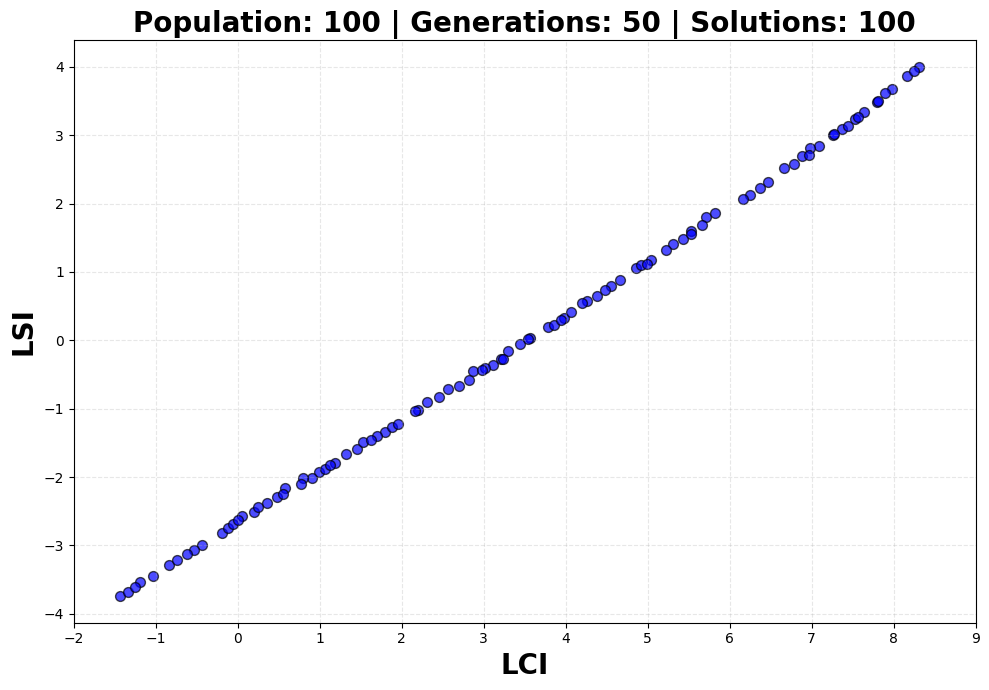


PARETO FRONT STATISTICS
Number of solutions in the front: 100

LCI (Least Coverage Index):
  - Range: [-1.4415, 8.3129]
  - Mean: 3.4736
  - Std. Dev.: 2.8329

LSI (Least Sparing Index):
  - Range: [-3.7425, 3.9992]
  - Mean: 0.0161
  - Std. Dev.: 2.2146

✓ Plot saved at: Muestra poblacional\IC\5079521\2\graficos_pareto\frente_pareto.png
  Resolution: 300 DPI


In [60]:
import matplotlib.pyplot as plt
import os

# Extraer valores LCI y LSI de las soluciones del frente de Pareto
lci_pareto = [-comp['objetivos'][0] for comp in comparaciones]
lsi_pareto = [comp['objetivos'][1] for comp in comparaciones]

# Crear figura con tamaño apropiado
fig, ax = plt.subplots(figsize=(10, 7))

# Graficar el frente de Pareto
ax.scatter(lci_pareto, lsi_pareto, c='blue', s=50, alpha=0.7, edgecolors='black', linewidth=1)

# Configurar etiquetas y título
ax.set_xlabel('LCI', fontsize=20, fontweight='bold')
ax.set_ylabel('LSI', fontsize=20, fontweight='bold')
ax.set_title(f'Population: 100 | Generations: {n_gen} | Solutions: {len(comparaciones)}', 
             fontsize=20, fontweight='bold')

# Configurar ticks para que LCI también varíe de 1 en 1
import numpy as np
lci_min = int(np.floor(min(lci_pareto)))
lci_max = int(np.ceil(max(lci_pareto)))
ax.set_xticks(range(lci_min, lci_max + 1, 1))

# Añadir grid
ax.grid(True, alpha=0.3, linestyle='--')

# Ajustar layout
fig.tight_layout()

# Guardar el gráfico
output_dir = os.path.join(directorio_estudio, 'graficos_pareto')
os.makedirs(output_dir, exist_ok=True)
archivo_pareto = os.path.join(output_dir, 'frente_pareto.png')
fig.savefig(archivo_pareto, dpi=300, bbox_inches='tight')

# Mostrar gráfico
plt.show()

# Imprimir estadísticas del frente de Pareto
print("\n" + "="*60)
print("PARETO FRONT STATISTICS")
print("="*60)
print(f"Number of solutions in the front: {len(comparaciones)}")
print(f"\nLCI (Least Coverage Index):")
print(f"  - Range: [{min(lci_pareto):.4f}, {max(lci_pareto):.4f}]")
print(f"  - Mean: {np.mean(lci_pareto):.4f}")
print(f"  - Std. Dev.: {np.std(lci_pareto):.4f}")
print(f"\nLSI (Least Sparing Index):")
print(f"  - Range: [{min(lsi_pareto):.4f}, {max(lsi_pareto):.4f}]")
print(f"  - Mean: {np.mean(lsi_pareto):.4f}")
print(f"  - Std. Dev.: {np.std(lsi_pareto):.4f}")
print("="*60)
print(f"\n✓ Plot saved at: {archivo_pareto}")
print(f"  Resolution: 300 DPI")